# Analyse over referanser

Lars G Johnsen, Kirsten Sivesind, Dijana Tiplic


Vi skal se på clustring basert på de bibliografiske dataene

In [1]:
import conc_coll_corpus as co
from conc_coll_corpus import zotero
import pandas as pd
import importlib as imp
import dhlab.module_update as mu

In [2]:
import igraph as ig
import leidenalg as la

from igraph import Graph
from leidenalg import find_partition
import numpy as np


In [3]:
import matplotlib.pyplot as plt

import matplotlib

In [4]:
imp.reload(ig)

<module 'igraph' from '/home/larsj/anaconda3/lib/python3.9/site-packages/igraph/__init__.py'>

In [238]:
def labelling(x, labels=labels):
    if x in labels:
        res = labels[x]
    else:
        res = ""
    return res

def do_betweenness(h, labels=labelling):
    df = pd.DataFrame([(a,b) for (a,b) in zip([x['name'] for x in h.vs], h.betweenness())])
    df.columns =['vertex', 'betweenness']
    df['name'] = df['vertex'].apply(lambda x: labels(x) )
    return df.sort_values(by='betweenness', ascending=False)

def in_degree(h, labels=labelling):
    df = pd.DataFrame([(a,b) for (a,b) in zip([x['name'] for x in h.vs], h.degree(mode='in'))])
    df.columns =['vertex', 'in_degree']
    df['name'] = df['vertex'].apply(lambda x: labels(x) )
    return df.sort_values(by='in_degree', ascending=False)

def out_degree(h, labels=labelling):
    df = pd.DataFrame([(a,b) for (a,b) in zip([x['name'] for x in h.vs], h.degree(mode='out'))])
    df.columns =['vertex', 'out_degree']
    df['name'] = df['vertex'].apply(lambda x: labels(x) )
    return df.sort_values(by='out_degree', ascending=False)


def degree(h, labels=labelling):
    df = pd.DataFrame([(a,b) for (a,b) in zip([x['name'] for x in h.vs], h.degree(mode='all'))])
    df.columns =['vertex', 'degree']
    df['name'] = df['vertex'].apply(lambda x: labels(x) )
    return df.sort_values(by='degree', ascending=False)

def degrees(h, labels = labelling):
    df_i = in_degree(h, labels = labels)
    df_o = out_degree(h, labels = labels)
    df_a = degree(h, labels = labels)
    df = pd.concat([df_i.set_index('vertex')[['in_degree']], df_o.set_index('vertex')[['out_degree']], df_a.set_index('vertex')], axis=1).reset_index()
    return df.sort_values(by='degree', ascending=False)


In [152]:

def make_clusters(g, iterations = 3):
    # Apply Leiden clustering
    partition = find_partition(g, la.ModularityVertexPartition, n_iterations=iterations)
    
    # Calculate degrees
    degrees = g.degree()
    
    # Normalize degree for size and transparency
    max_degree = max(degrees)
    
    min_size, max_size = 10, 50  # adjust as needed
    sizes = [min_size + (d / max_degree) * (max_size - min_size) for d in degrees]

    min_size, max_size = 4, 20  # adjust as needed
    label_sizes = [min_size + (d / max_degree) * (max_size - min_size) for d in degrees]
    
    
    max_alpha = 0.8
    alphas = [max_alpha - (d / max_degree) * max_alpha for d in degrees]
    
    # Create a color palette using matplotlib
    
    n_communities = len(partition)
    
    colors_rgb = plt.cm.tab20(np.linspace(0, 1, n_communities))
    
    
    def rgba_to_hex(rgba):
        r, g, b, a = rgba
        return "#{:02x}{:02x}{:02x}{:02x}".format(int(r*255), int(g*255), int(b*255), int(a*255))
    
    # Adjust the alpha channel for each community color based on node degree
    colors_hex = [rgba_to_hex((r, g, b, alphas[i])) for i, (r, g, b, a) in enumerate(colors_rgb)]
    
    # Assign these as attributes of the vertices in the graph
    g.vs["color"] = [colors_hex[part] for part in partition.membership]
    g.vs["size"] = sizes
    g.vs["label_size"] = label_sizes
    # Now plot the partition, which will use the vertex attributes we've just set
    
    
    
    vertex_colors = [rgba_to_hex((colors_rgb[partition.membership[i]][0], 
                                 colors_rgb[partition.membership[i]][1], 
                                 colors_rgb[partition.membership[i]][2], 
                                 alphas[i])) for i in range(len(g.vs))]
    
    # Assign the calculated colors to the vertices
    g.vs["color"] = vertex_colors
    return partition



In [22]:
def col2hex(color, alpha=0.5):
    return matplotlib.colors.rgb2hex(matplotlib.colors.to_rgba(color, alpha=alpha), keep_alpha=True)

In [7]:
def map(x, a=1, b=0, c=10, d=0):
    """map interval a b to c d"""
    return c + ((d - c)/(b - a))*(x - a)

In [8]:
mu.css()

In [9]:
map(5, a= 20, b=0, c=50, d=0)

12.5

In [198]:
def plotgraph(h, target=None, degree='all', bbox=(800,800), show_labels=True):
    visual_style = {}
    g = h.copy()
    
    degrees = g.degree(mode=degree)
    max_degree = max(degrees)
    # node size

    min_size, max_size = 10, 50  # adjust as needed
    sizes = [min_size + (d / max_degree) * (max_size - min_size) for d in degrees]
    
    visual_style['vertex_size'] = sizes
    
    # Normalize degree for size and transparency
    
    min_size, max_size = 4, 20  # adjust as needed
    label_sizes = [min_size + (d / max_degree) * (max_size - min_size) for d in degrees]
    if show_labels:
        g.vs['label_size'] = label_sizes
    else:
        g.vs['label_size'] = 0
        
    visual_style["edge_width"] = 0.3
    visual_style['edge_arrow_size'] = 0.5
    visual_style["edge_color"] = matplotlib.colors.rgb2hex(matplotlib.colors.to_rgba('blue', alpha=0.2), keep_alpha=True)
    #visual_style['edge_color'] = matplotlib.colors.rgb2hex(matplotlib.colors.to_rgba('slategrey', alpha=0.2), keep_alpha=True)
    visual_style["bbox"] = bbox
    #layout = Graph.layout_graphopt
    layout = g.layout_fruchterman_reingold()
    return ig.plot(g, layout = layout, target=target, **visual_style)

Mesteparten av koden ligger i modulen kalt _co_ i importlisten. Den modulen henter inn metadataen også, som blir referert til med variabelen _co.zotero_.

In [189]:
#corpus_name = "sub_corpus/POLNET_tom2016_load0250321.xlsx"

def make_edge_list(excel_file):
    corpus_name = excel_file
    subcorpus = pd.read_excel(corpus_name)    
    referanser = list(subcorpus[['Key','Notes']].to_records())
    
    import re
    
    # Henter ut referansene og lager en graf som en liste av buer. Selve konstruksjonen kan tas skritt for skritt ved en anledning.
    
    reference_dict = {
        referanser[i][1]:re.findall("<p>([0-9A-Z]+)</p>", referanser[i][2]) 
        for i in range(len(referanser)) 
        if  type(referanser[i][2]) is str
    }
    edge_list = [(x, y) for x in reference_dict for y in reference_dict[x] ]
    
    return edge_list

In [187]:
co.zotero.head(2)

,Key,Item Type,Publication Year,Author,Title,Publication Title,ISBN,Departement,Utdanning,Reform,...,Version,System,Code,Code Number,Section,Session,Committee,History,Legislative Body,Type
0,NHG4G4L4,book,1990,Sosialdepartementet,NOU 1990: 17 Uførepensjon,NaN,978-82-583-0212-1,Sosial,Andre,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOU
1,CDEE3MMB,book,1991,Arbeids- og administrasjonsdepartementet,NOU 1991: 26 Om bruk av styrer i statlige virk...,NaN,978-82-583-0238-1,Administrasjon,Andre,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NOU


# Edgelist and the documents

In [190]:
excel_file = "POLNET_from1988_load091220c.xlsx"
edge_list = make_edge_list(excel_file)


I visningen av clustre skal vi bruke tittelen som navn på noden. Navnet hentes fra det som ligger i kolonne _Title_. Her kan vi lage kombinasjoner og andre ting. 

In [192]:
longlabels = dict([(x[0], x[1]) for x in co.zotero[['Key', 'Title']].values])
labels = {x:' '.join(longlabels[x].split()[:4]) for x in longlabels}


Oversettelsen fra nøkler (Key) til tittel er ikke helt perfekt, men vi kan se mer på det.

# Kjør Leiden-algoritmen på dokumentene
Bruker igraph for grafkonstruksjon. Lager en graf fra `edge_list` som er hentet fra POLNET-databasen.

In [153]:

# snur på rekkefølgen av tuplene sånn at pilen går mot referansen

h = ig.Graph.TupleList([(x[1],x[0]) for x in edge_list if x[1]!=x[0]], directed=True)

# Utstyr nodene med navn på dokument

for v in h.vs:
    try:
        v['label'] = labels[v['name']]
    except:
        v['label'] = "---"

In [196]:
# make_clusters angir fargekode til nodene i h basert på clusteret de er i

partition = make_clusters(h, iterations=-1)

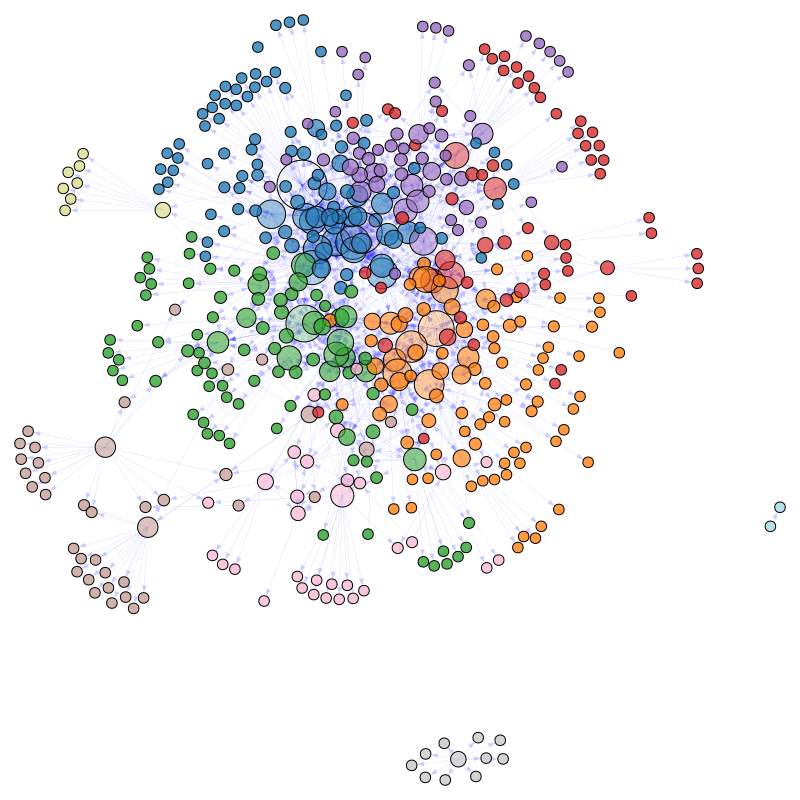

In [226]:
plotgraph(h, degree='all', show_labels=False)

## Store the graphs as png-files

In [209]:
def store_graphs(listofgraphs, degree='all', folder = "figures"):
    #plotgraph(h, target=os.path.join('figures', f"subgraph_png_main.png"))
    for i, g in enumerate(listofgraphs):
        #change_font_in(g)
        plotgraph(g, target = os.path.join(folder, f"subgraph_png_{i}_{degree}.png"), degree=degree)

In [216]:
for t in ["in", "out"]:
    store_graphs([h] + partition.subgraphs(), folder='graphs', degree=t)

## Represent clusters in pandas

In [239]:
polnet_groups = []
for i, psg in enumerate(partition.subgraphs()):
    df = degrees(psg, labels=lambda x:labelling(x, longlabels))
    df['cluster'] = i
    polnet_groups.append(df)
polnet_cluster = pd.concat(polnet_groups)

In [242]:
polnet_cluster.to_excel('Polnet_cluster_in_out_all.xlsx')

In [269]:
polnet_groups[1].head()

,vertex,in_degree,out_degree,degree,name,cluster
10,PY7VZARY,6,22,28,NOU 1999: 33 Nyttige lærepenger - om utdanning...,1
8,JQNL2KII,6,19,25,NOU 2000: 14 Frihet med ansvar om høyere utdan...,1
1,GVLDYG9U,10,10,20,NOU 1988: 28 Med viten og vilje,1
19,93EJ6DH8,4,16,20,St.meld. nr. 36 (1998-99) Om prinsipper for di...,1
0,3SN7EBSL,12,6,18,St.meld. nr. 40 (1990—91) Fra visjon til virke...,1


In [250]:
pd.concat([df.sort_values(by='in_degree', ascending=False)[['name','cluster']].head(2) for df in polnet_groups]).style

,name,cluster
0,St.meld. nr. 16 (2006-2007) ... og ingen sto igjen Tidlig innsats for livslang læring,0
1,St.meld. nr. 30 (2003-2004) Kultur for læring,0
0,St.meld. nr. 40 (1990—91) Fra visjon til virke Om høgre utdanning,1
1,NOU 1988: 28 Med viten og vilje,1
0,St.meld. nr. 37 (1990—91) Om organisering og styring i utdanningssektoren,2
1,St.meld. nr. 43 (1988-89) Mer kunnskap til flere,2
0,St.meld. nr. 20 (2004-2005) Vilje til forskning,3
1,St.meld. nr. 39 (1998-99) Forskning ved et tidsskille,3
0,St.meld. nr. 18 (2014-2015) Konsentrasjon for kvalitet Strukturreform i universitets- og høyskolesektoren,4
1,St.meld. nr. 16 (2016–2017) Kultur for kvalitet i høyere utdanning,4


In [249]:
pd.concat([df.sort_values(by='out_degree', ascending=False)[['name','cluster']].head(2) for df in polnet_groups]).style

,name,cluster
101,NOU 2019: 23 Ny opplæringslov,0
39,NOU 2012: 1 Til barnas beste Ny lovgivning for barnehagene,0
10,NOU 1999: 33 Nyttige lærepenger - om utdanningsfinansiering gjennom Lånekassen,1
8,NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge,1
11,"NOU 1995: 18 Ny lovgivning om opplæring ""... og for øvrig kan man gjøre som man vil""",2
64,"NOU 1989: 13 Grenseløs læring mottak av utenlandske studenter, studentutveksling og internasjonalisering",2
20,St.meld. nr. 13 (2011–2012) Utdanning for velferd Samspill i praksis,3
60,St.meld. nr. 18 (2012–2013) Lange linjer – kunnskap gir muligheter,3
8,"NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring",4
22,St.meld. nr. 4 (2018–2019) Langtidsplan for forskning og høyere utdanning 2019 - 2028,4


In [227]:
pd.concat([df.sort_values(by='degree', ascending=False)[['name','cluster']].head(2) for df in polnet_groups]).style

,name,cluster
11,NOU 2019: 23 Ny opplæringslov,0
17,NOU 2009: 18 Rett til læring,0
11,NOU 1999: 33 Nyttige lærepenger - om utdanningsfinansiering gjennom Lånekassen,1
5,NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge,1
2,"NOU 1995: 18 Ny lovgivning om opplæring ""... og for øvrig kan man gjøre som man vil""",2
29,"St.meld. nr. 54 (1989-90) Om opplæring av barn, unge og voksne med særskilte behov.",2
0,St.meld. nr. 13 (2011–2012) Utdanning for velferd Samspill i praksis,3
1,St.meld. nr. 18 (2012–2013) Lange linjer – kunnskap gir muligheter,3
5,"NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring",4
8,St.meld. nr. 4 (2018–2019) Langtidsplan for forskning og høyere utdanning 2019 - 2028,4


In [98]:
pd.concat([df.sort_values(by='degree', ascending=False)[['name','cluster']].head(2) for df in polnet_groups]).style

,name,cluster
13,NOU 2019: 23 Ny opplæringslov,0
26,"NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring",0
6,"NOU 1995: 18 Ny lovgivning om opplæring ""... og for øvrig kan man gjøre som man vil""",1
12,"St.meld. nr. 40 (1992—93) ... vi smaa, en Alen lange; Om 6-åringer i skolen - konsekvenser for skoleløpet og retningslinjer for dets innhold",1
0,St.meld. nr. 13 (2011–2012) Utdanning for velferd Samspill i praksis,2
4,St.meld. nr. 4 (2018–2019) Langtidsplan for forskning og høyere utdanning 2019 - 2028,2
3,NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge,3
11,St.meld. nr. 27 (2000-2001) Gjør din plikt - Krev din rett Kvalitetsreform av høyere utdanning,3
0,NOU 1988: 28 Med viten og vilje,4
4,NOU 1986: 23 Livslang læring,4


In [103]:
pd.concat([df.sort_values(by='degree', ascending=False)[['name','cluster']].head(2) for df in polnet_groups]).style

,name,cluster
10,NOU 2019: 23 Ny opplæringslov,0
23,"NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring",0
4,"NOU 1995: 18 Ny lovgivning om opplæring ""... og for øvrig kan man gjøre som man vil""",1
14,NOU 1988: 28 Med viten og vilje,1
0,St.meld. nr. 13 (2011–2012) Utdanning for velferd Samspill i praksis,2
1,St.meld. nr. 18 (2012–2013) Lange linjer – kunnskap gir muligheter,2
3,NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge,3
10,St.meld. nr. 27 (2000-2001) Gjør din plikt - Krev din rett Kvalitetsreform av høyere utdanning,3
7,NOU 1999: 33 Nyttige lærepenger - om utdanningsfinansiering gjennom Lånekassen,4
8,St.meld. nr. 36 (1998-99) Om prinsipper for dimensjonering av høgre utdanning,4


# Do year span for the graphs

In [462]:

cluster_names = {
    "0": {
        "english": "Quality and early learning interventions",  #Early Learning Interventions",
        "name": [
            "St.meld. nr. 16 (2006-2007) ... og ingen sto igjen Tidlig innsats for livslang læring",
            "St.meld. nr. 30 (2003-2004) Kultur for læring"
        ]
    },
    "1": {
        "english": "Higher Education Vision & Initiative",
        "name": [
            "St.meld. nr. 40 (1990—91) Fra visjon til virke Om høgre utdanning",
            "NOU 1988: 28 Med viten og vilje"
        ]
    },
    "2": {
        "english": "Education Sector Organization & Outreach",
        "name": [
            "St.meld. nr. 37 (1990—91) Om organisering og styring i utdanningssektoren",
            "St.meld. nr. 43 (1988-89) Mer kunnskap til flere"
        ]
    },
    "3": {
        "english": "Research Focus & Milestones",
        "name": [
            "St.meld. nr. 20 (2004-2005) Vilje til forskning",
            "St.meld. nr. 39 (1998-99) Forskning ved et tidsskille"
        ]
    },
    "4": {
        "english": "University & College Structural Reforms",
        "name": [
            "St.meld. nr. 18 (2014-2015) Konsentrasjon for kvalitet Strukturreform i universitets- og høyskolesektoren",
            "St.meld. nr. 16 (2016–2017) Kultur for kvalitet i høyere utdanning"
        ]
    },
    "5": {
        "english": "Sami Culture & Education",
        "name": [
            "NOU 1980: 59 Samisk i grunnskolen",
            "NOU 1987: 34 Samisk kultur og utdanning: de enkelte sektorer, administrasjon"
        ]
    },
    "6": {
        "english": "Digital Technology in Education",
        "name": [
            "St.meld. nr. 39 (1983-84) DATATEKNOLOGI I SKOLEN",
            "St.meld. nr. 37 (1987-88) Om datateknologi i skole og opplæring"
        ]
    },
    "7": {
        "english": "Broadcasting & Radio Legislation",
        "name": [
            "NOU 1975: 7 Kringkastingslov",
            "NOU 1982: 33 Nærradio"
        ]
    },
    "8": {
        "english": "Police Role & Prosecution in Society",
        "name": [
            "NOU 1981: 35 Politiets rolle i samfunnet:delutredning I",
            "NOU 1988: 39 Politi og påtalemyndighet:arbeids- og ansvarsfordeling : utredning fra et utvalg oppnevnt ved kongelig resolusjon av 16. januar 1987 : avgitt til Justis- og politidepartementet november 1988"
        ]
    },
    "9": {
        "english": "School Start Costs & Infrastructure",
        "name": [
            "NOU 1995: 13 Kostnader ved skolestart for seksåringer: utredning fra et utvalg oppnevnt ved kongelig resolusjon 6. mai 1994 ; avgitt til Finans- og tolldepartementet 7. april 1995",
            "St.meld. nr. 21 (1996—97) Finansiering av lærebøker for 2. - 10. klassetrinn og status for tilrettelegging av skolelokaler til seksåringer i forbindelse med Reform 97"
        ]
    }
}


In [265]:
polnet_groups[1].head()

,vertex,in_degree,out_degree,degree,name,cluster
10,PY7VZARY,6,22,28,NOU 1999: 33 Nyttige lærepenger - om utdanning...,1
8,JQNL2KII,6,19,25,NOU 2000: 14 Frihet med ansvar om høyere utdan...,1
1,GVLDYG9U,10,10,20,NOU 1988: 28 Med viten og vilje,1
19,93EJ6DH8,4,16,20,St.meld. nr. 36 (1998-99) Om prinsipper for di...,1
0,3SN7EBSL,12,6,18,St.meld. nr. 40 (1990—91) Fra visjon til virke...,1


In [132]:
zotero.columns

Index(['Key', 'Item Type', 'Publication Year', 'Author', 'Title',
       'Publication Title', 'ISBN', 'Departement', 'Utdanning', 'Reform',
       'Tematisk utvalg', 'Url', 'Abstract Note', 'Date', 'Date Added',
       'Date Modified', 'Access Date', 'Pages', 'Num Pages', 'Issue', 'Volume',
       'Number Of Volumes', 'Journal Abbreviation', 'Short Title', 'Series',
       'Series Number', 'Series Text', 'Series Title', 'Publisher', 'Place',
       'Language', 'Rights', 'Type2', 'Archive', 'Archive Location',
       'Library Catalog', 'Call Number', 'Extra', 'Notes', 'File Attachments',
       'Link Attachments', 'Manual Tags', 'Automatic Tags', 'Editor',
       'Series Editor', 'Translator', 'Contributor', 'Attorney Agent',
       'Book Author', 'Cast Member', 'Commenter', 'Composer', 'Cosponsor',
       'Counsel', 'Interviewer', 'Producer', 'Recipient', 'Reviewed Author',
       'Scriptwriter', 'Words By', 'Guest', 'Number', 'Edition',
       'Running Time', 'Scale', 'Medium', 'Artwo

In [284]:
def year_span(g, column="counts"):
    df = g.merge(zotero[['Key','Publication Year']], left_on='vertex', right_on='Key')
    res = pd.DataFrame(df.groupby('Publication Year').count()['vertex'])
    res.columns = [column]
    return res
    

In [148]:
import os

numrows = len(polnet_groups)
fig, ax = plt.subplots(numrows, 1, figsize=(10,5 * numrows))  # Adjust the total figure height based on the number of rows
for i, g in enumerate(polnet_groups):
    year_span(g).plot(kind='bar', ax = ax[i],rot=40, title = cluster_names[str(i)]['english'])
plt.subplots_adjust(hspace=0.5) 


De mest sentrale dokumentene basert på _betweenness_

In [463]:
df = pd.concat([year_span(g, column = cluster_names[str(i)]["english"]) for i, g in enumerate(polnet_groups)], axis=1).fillna(0)

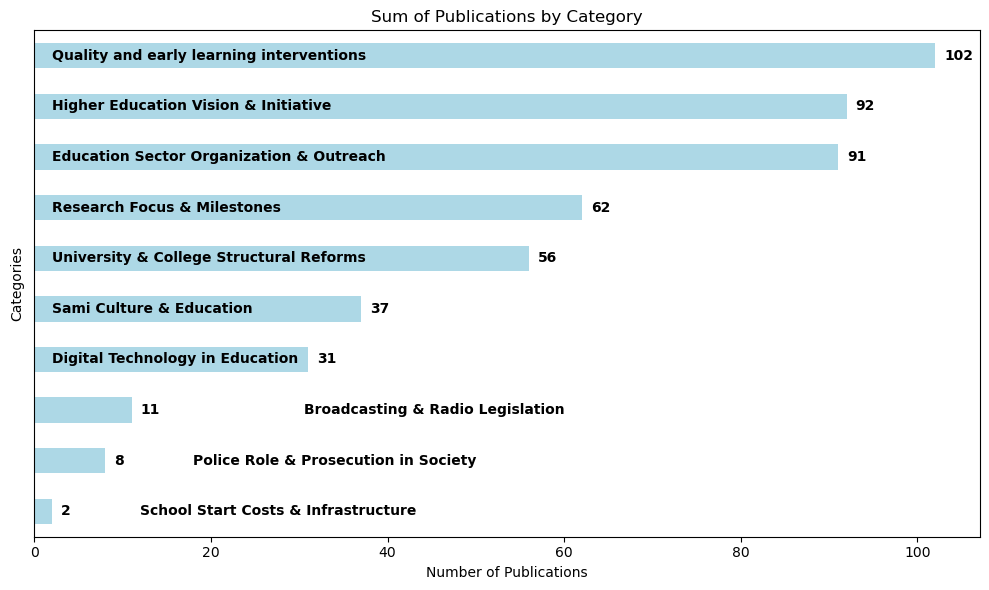

In [464]:
sums = df.sum().sort_values()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create a horizontal bar plot
bars = sums.plot(kind='barh', ax=ax, color='lightblue')

ax.set_yticks([])



# Annotate the bars with category names and sums
for i, bar in enumerate(bars.patches):
    width = bar.get_width()

    # Estimate the space required by the sum value text
    value_text = str(int(width))
    value_placeholder = ax.text(0, 0, value_text, fontweight='bold')
    value_text_width = value_placeholder.get_window_extent().width
    value_placeholder.remove()

    # Annotate sum values
    ax.text(width + 0.01 * max(sums),
            bar.get_y() + bar.get_height() / 2,
            value_text,
            ha='left', va='center', color='black', fontweight='bold')

    # Decide where to place the category name text
    text_position = 0.02 * max(sums)
    if width < value_text_width + 0.05 * max(sums):
        text_position = width + value_text_width + 0.003 * max(sums)

    # Annotating category names
    ax.text(text_position,
            bar.get_y() + bar.get_height() / 2,
            sums.index[i],
            ha='left', va='center', color='black', fontweight='bold')

ax.set_title("Sum of Publications by Category")
ax.set_xlabel("Number of Publications")
ax.set_ylabel("Categories")

plt.tight_layout()


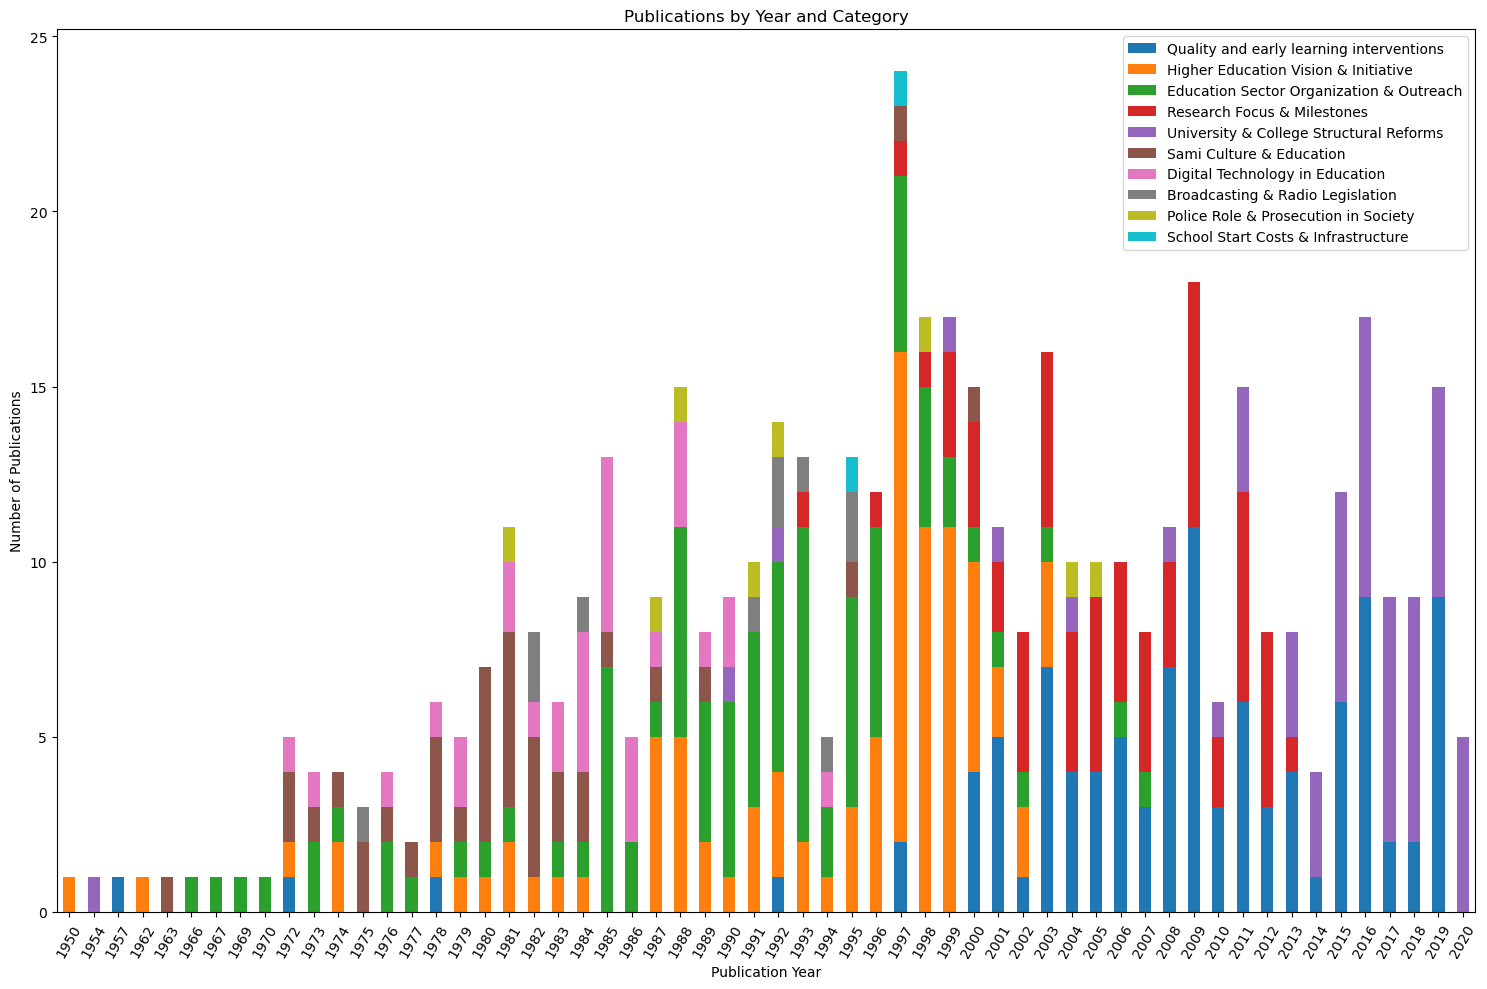

In [465]:
df.sort_index().plot(kind='bar', rot=60, stacked=True, figsize=(15,10))
plt.title("Publications by Year and Category")
plt.ylabel("Number of Publications")
plt.xlabel("Publication Year")
plt.tight_layout()
plt.show()

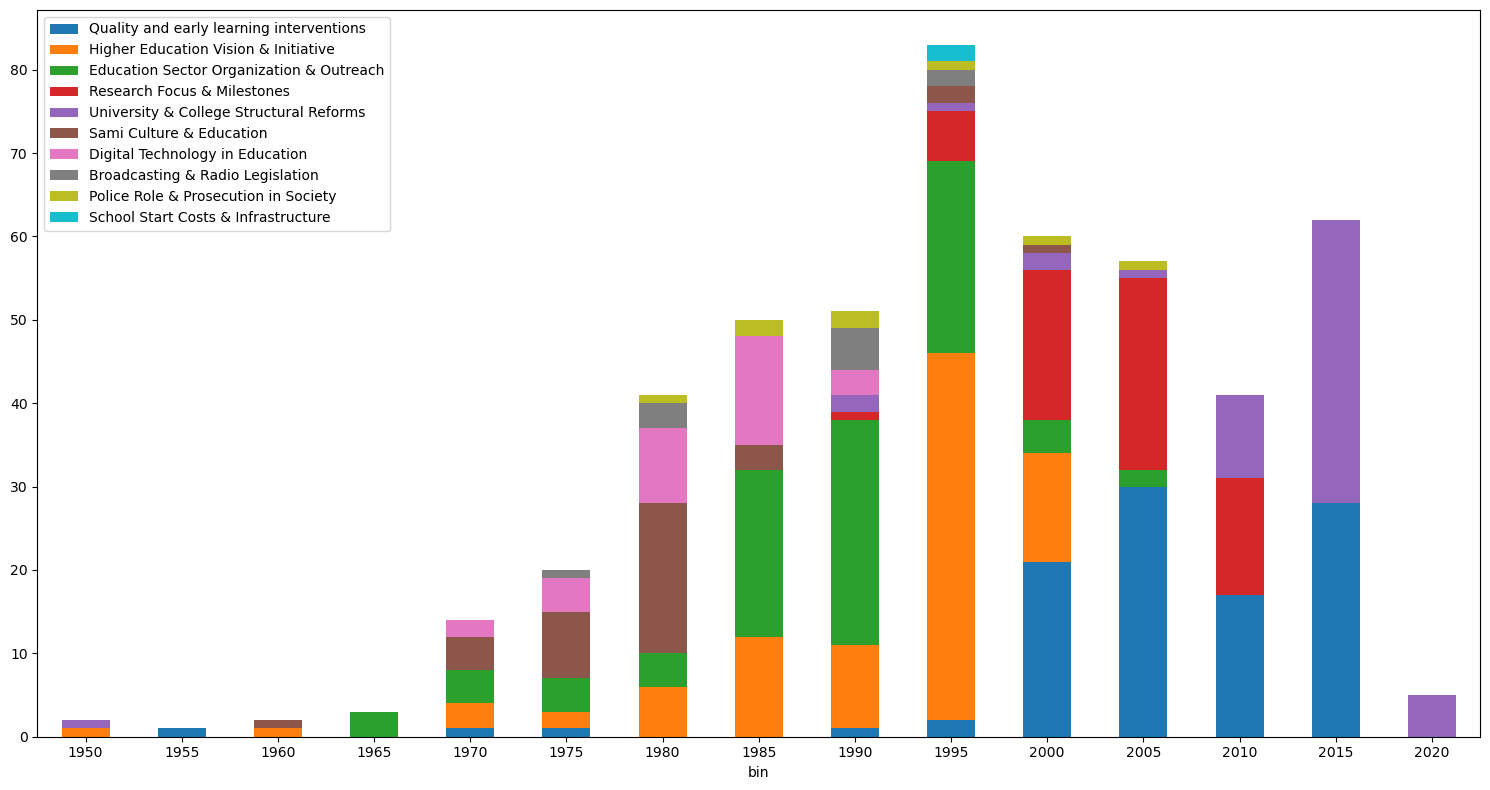

In [490]:

df0 = df.reset_index()

df0['Publication Year'] = pd.to_datetime(df0['Publication Year'], format='%Y')

# Create a new 'bin' column to store binned years
df0['bin'] = df0['Publication Year'].dt.year // 5 * 5

# Group by the 'bin' and aggregate by summing up the values
df_binned = df0.groupby('bin').sum().reset_index()

df_binned.set_index('bin').plot(kind='bar', stacked=True, figsize=(15,8), rot=0)
#df.sort_index().plot(kind='bar', rot=60, stacked=True, figsize=(15,10))

plt.tight_layout()
plt.show()

In [370]:
polnet_words.sum()

Early Learning Interventions                5542633.0
Higher Education Vision & Initiative        5576555.0
Education Sector Organization & Outreach    4103542.0
Research Focus & Milestones                 2447889.0
University & College Structural Reforms     1463332.0
Sami Culture & Education                    1440967.0
Digital Technology in Education              237462.0
Broadcasting & Radio Legislation             166649.0
Police Role & Prosecution in Society          14806.0
School Start Costs & Infrastructure           11875.0
dtype: float64

In [467]:
polnet_words = pd.concat([co.corpus_text(pg.vertex.values, columns=cluster_names[str(i)]["english"]) for i, pg in enumerate(polnet_groups)], axis = 1)

In [468]:
polnet_words_rel = polnet_words*10000/polnet_words.sum()

In [491]:
IOs = "OECD TIMSS SITES ICILS ICCS PIRLS PISA TALIS PIAAC IEA UNESCO FN EU".split()

In [492]:
polnet_words_rel.loc[IOs].fillna(0).style.format(precision=3).background_gradient(axis=1)

,Quality and early learning interventions,Higher Education Vision & Initiative,Education Sector Organization & Outreach,Research Focus & Milestones,University & College Structural Reforms,Sami Culture & Education,Digital Technology in Education,Broadcasting & Radio Legislation,Police Role & Prosecution in Society,School Start Costs & Infrastructure
OECD,1.755,0.889,0.409,1.422,4.934,0.028,1.221,0.120,0.000,0.000
TIMSS,0.148,0.000,0.010,0.004,0.014,0.000,0.000,0.000,0.000,0.000
SITES,0.009,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
ICILS,0.007,0.000,0.000,0.000,0.021,0.000,0.000,0.000,0.000,0.000
ICCS,0.016,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
PIRLS,0.134,0.000,0.000,0.012,0.027,0.000,0.000,0.000,0.000,0.000
PISA,0.321,0.004,0.002,0.049,0.096,0.000,0.000,0.000,0.000,0.000
TALIS,0.031,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
PIAAC,0.011,0.000,0.000,0.000,0.089,0.000,0.000,0.000,0.000,0.000
IEA,0.040,0.002,0.007,0.061,0.116,0.000,0.000,0.000,0.000,0.000


In [471]:
polnet_words.loc["EU OECD TIMSS PISA IEA UNESCO FN".split()].fillna(0).style.format(precision=0).background_gradient(axis=1)

,Quality and early learning interventions,Higher Education Vision & Initiative,Education Sector Organization & Outreach,Research Focus & Milestones,University & College Structural Reforms,Sami Culture & Education,Digital Technology in Education,Broadcasting & Radio Legislation,Police Role & Prosecution in Society,School Start Costs & Infrastructure
EU,473,361,22,412,192,3,0,6,0,0
OECD,973,496,168,348,722,4,29,2,0,0
TIMSS,82,0,4,1,2,0,0,0,0,0
PISA,178,2,1,12,14,0,0,0,0,0
IEA,22,1,3,15,17,0,0,0,0,0
UNESCO,31,109,51,39,12,16,8,0,0,0
FN,35,65,45,102,29,238,1,0,0,0


In [376]:
norden_land = "Norge Finland Sverige Danmark".split()
norden_adj = "norsk norske finsk finske svensk svenske norden nordisk nordiske".split()
norden_adj += [x.capitalize() for x in norden_adj]
norden = norden_land + norden_adj

In [472]:
allwords = polnet_words_rel.loc[norden].fillna(0)
groupings = allwords.groupby(allwords.index.str.capitalize()).sum()
groupings.style.format(precision=3).background_gradient(axis=1)

,Quality and early learning interventions,Higher Education Vision & Initiative,Education Sector Organization & Outreach,Research Focus & Milestones,University & College Structural Reforms,Sami Culture & Education,Digital Technology in Education,Broadcasting & Radio Legislation,Police Role & Prosecution in Society,School Start Costs & Infrastructure
Danmark,1.083,0.993,0.826,1.140,2.815,0.347,0.716,2.880,3.377,0.000
Finland,0.924,0.818,0.609,1.136,1.141,3.026,0.674,1.980,2.702,0.000
Finsk,0.175,0.072,0.327,0.016,0.027,1.645,0.084,0.300,2.026,0.000
Finske,0.159,0.133,0.175,0.131,0.075,1.270,0.253,0.780,2.702,0.000
Norden,0.309,0.481,0.373,0.617,0.574,0.847,0.632,0.120,0.675,0.000
Nordisk,0.729,1.763,0.887,1.254,0.273,6.766,1.811,0.480,1.351,0.000
Nordiske,0.969,1.734,1.170,1.275,1.360,2.700,1.305,0.840,3.377,0.000
Norge,11.076,9.931,7.866,17.587,25.121,10.875,4.801,8.341,5.403,0.000
Norsk,8.274,10.637,9.463,10.862,9.205,18.307,7.454,8.761,6.079,0.000
Norske,5.393,8.554,9.338,7.954,9.895,13.269,4.085,3.840,6.079,0.000


In [378]:
ppt_ord = """Grunnlov
Formål
Normer
Verdier
Rettigheter
Flerkulturell
Mangfold
mangfoldig
Religion
Tospråklige
Skole
Skoleeier
Oppgavefordeling
Undervisning
Ledelse
""".split()
ppt_ord += [x.lower() for x in ppt_ord]
ppt_ord = list(set(ppt_ord))

In [473]:
df_p = polnet_words_rel.loc[ppt_ord]
grouped = df_p.groupby(df_p.index.str.capitalize()).sum()

In [474]:
grouped.fillna(0).style.format(precision=3).background_gradient(axis=1)

,Quality and early learning interventions,Higher Education Vision & Initiative,Education Sector Organization & Outreach,Research Focus & Milestones,University & College Structural Reforms,Sami Culture & Education,Digital Technology in Education,Broadcasting & Radio Legislation,Police Role & Prosecution in Society,School Start Costs & Infrastructure
Flerkulturell,0.224,0.029,0.090,0.172,0.014,0.173,0.042,0.000,0.000,0.000
Formål,1.618,1.632,2.003,2.051,1.189,1.575,1.474,1.500,2.026,0.000
Grunnlov,0.052,0.011,0.058,0.049,0.007,0.632,0.126,0.000,0.000,0.000
Ledelse,0.864,1.644,0.985,1.659,1.353,0.396,0.716,0.600,0.000,0.000
Mangfold,1.732,0.828,0.441,2.083,0.533,0.347,0.211,0.840,0.000,0.000
Mangfoldig,0.180,0.088,0.115,0.131,0.164,0.014,0.168,0.120,0.000,0.000
Normer,0.350,0.204,0.509,0.425,0.294,0.382,0.253,0.000,0.000,0.000
Oppgavefordeling,0.038,0.016,0.015,0.139,0.021,0.000,0.000,0.000,0.000,0.000
Religion,0.227,0.036,1.599,0.899,0.096,0.562,0.211,0.000,0.000,0.000
Rettigheter,2.834,0.762,1.565,3.129,1.661,6.600,0.842,0.180,4.728,0.000


In [388]:
translated_index = [
    "Multicultural",
    "Purpose/Objective",
    "Constitution",
    "Leadership/Management",
    "Diversity",
    "Diverse",
    "Norms",
    "Task distribution",
    "Religion",
    "Rights",
    "School",
    "School owner",
    "Bilinguals",
    "Teaching/Education",
    "Values"
]


In [390]:
grouped.insert(0, 'English Translation', translated_index)

In [412]:
[co.zotero_text('PY7VZARY').get(x) for x in ppt_ord]

[None,
 2,
 None,
 None,
 None,
 None,
 None,
 11,
 None,
 None,
 None,
 None,
 None,
 4,
 1,
 1,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 33,
 None,
 None,
 9,
 None,
 197]

In [430]:
import sqlite3
def make_unigrams(zid):
    res = co.zotero_text(zid)
    with sqlite3.connect("unigrams.db") as con:
        rows = [(zid, key, res[key]) for key in res]
        df = pd.DataFrame(rows, columns=["identifier", "word", "frequency"])
        # Store the dataframe to SQLite
        df.to_sql('word_freq', con, if_exists='append', index=False)
    return len(res)






In [431]:
for v in polnet_cluster.vertex:
    make_unigrams(v)

In [435]:
with sqlite3.connect('unigrams.db') as con:
    polnet_dtm = pd.read_sql( "select * from word_freq", con)

In [439]:
word_year = polnet_dtm.merge(zotero[["Key","Publication Year"]], left_on="identifier", right_on="Key")

In [448]:
trends = word_year.groupby(['word','Publication Year']).sum()

In [535]:
trends

identifier frequency       Key
word     Publication Year                               
!        1970               NA5JTD78        59  NA5JTD78
         1972               235TMJP4        12  235TMJP4
         1980               M3MI9IHT         1  M3MI9IHT
         1981               4VSAZ6YN         6  4VSAZ6YN
         1983               7P4X3G4E         2  7P4X3G4E
...                              ...       ...       ...
ﬂraceﬂ   2011               C3II3FX6         1  C3II3FX6
ﬂracial  2011               C3II3FX6         1  C3II3FX6
ﬂraseﬂ   2011               C3II3FX6         1  C3II3FX6
ﬂsubstan 2009               G73KS8UQ         1  G73KS8UQ
ﬂvanlig  2011               67IANJIE         1  67IANJIE

[1643430 rows x 3 columns]

<AxesSubplot: xlabel='bin'>

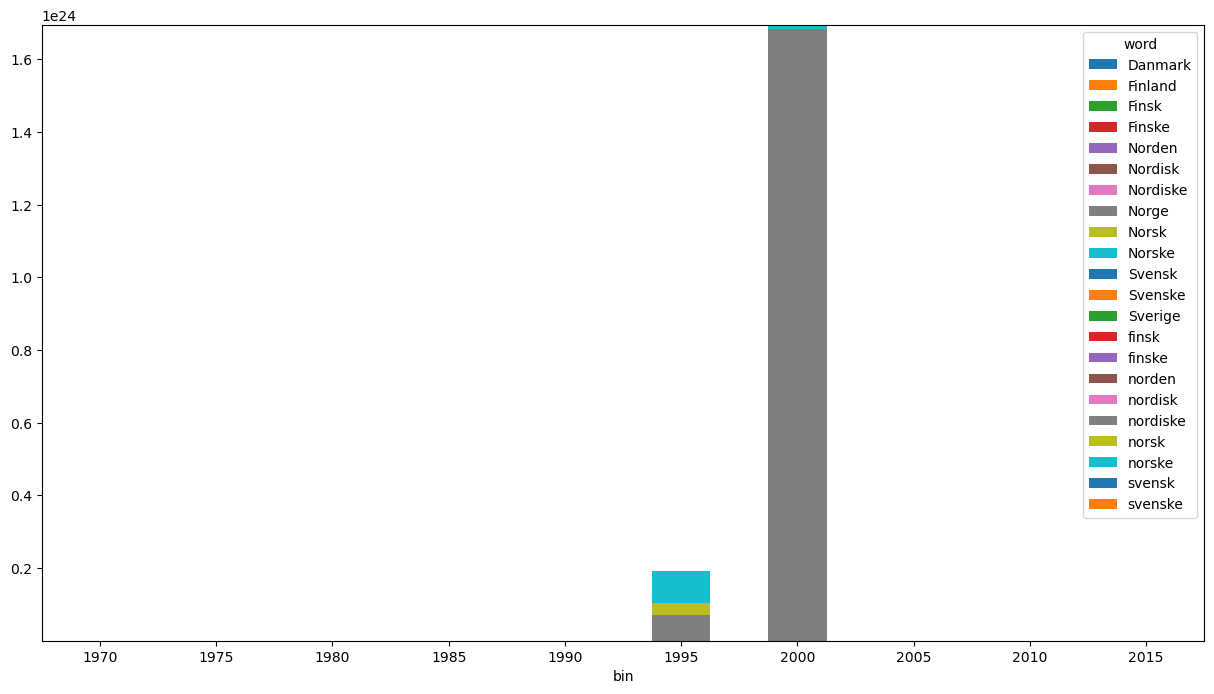

In [533]:
triple = trends.loc[norden].reset_index()[['word', 'Publication Year', 'frequency']]

df_pivot = triple.pivot(index='Publication Year', columns='word', values='frequency').fillna(0)

df_pivot = df_pivot.apply(pd.to_numeric, errors='coerce')


df0 = df_pivot.reset_index()

df0['Publication Year'] = pd.to_datetime(df0['Publication Year'], format='%Y')

# Create a new 'bin' column to store binned years
df0['bin'] = df0['Publication Year'].dt.year // 5 * 5

# Group by the 'bin' and aggregate by summing up the values
df_binned = df0.groupby('bin').sum().reset_index()

df_binned.set_index('bin').plot(kind='bar', stacked=True, figsize=(15,8), rot=0)

<AxesSubplot: xlabel='bin'>

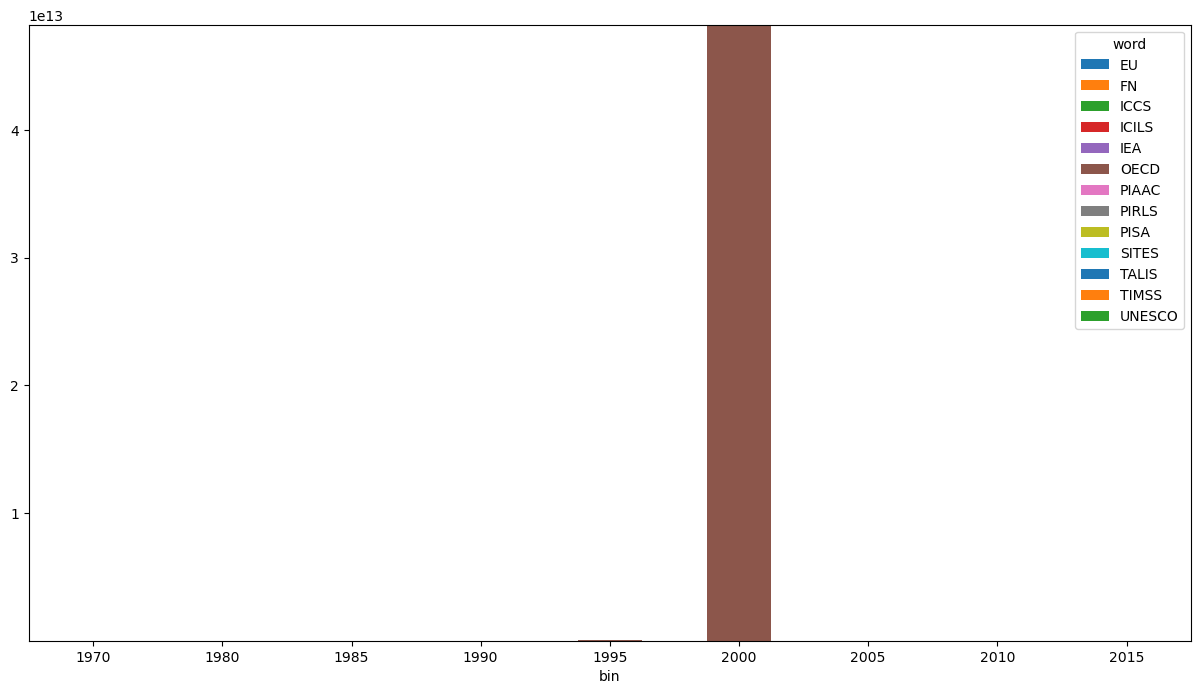

In [534]:
triple = trends.loc[IOs].reset_index()[['word', 'Publication Year', 'frequency']]

df_pivot = triple.pivot(index='Publication Year', columns='word', values='frequency').fillna(0)

df_pivot = df_pivot.apply(pd.to_numeric, errors='coerce')


df0 = df_pivot.reset_index()

df0['Publication Year'] = pd.to_datetime(df0['Publication Year'], format='%Y')

# Create a new 'bin' column to store binned years
df0['bin'] = df0['Publication Year'].dt.year // 5 * 5

# Group by the 'bin' and aggregate by summing up the values
df_binned = df0.groupby('bin').sum().reset_index()

df_binned.set_index('bin').plot(kind='bar', stacked=True, figsize=(15,8), rot=0)

<AxesSubplot: xlabel='bin'>

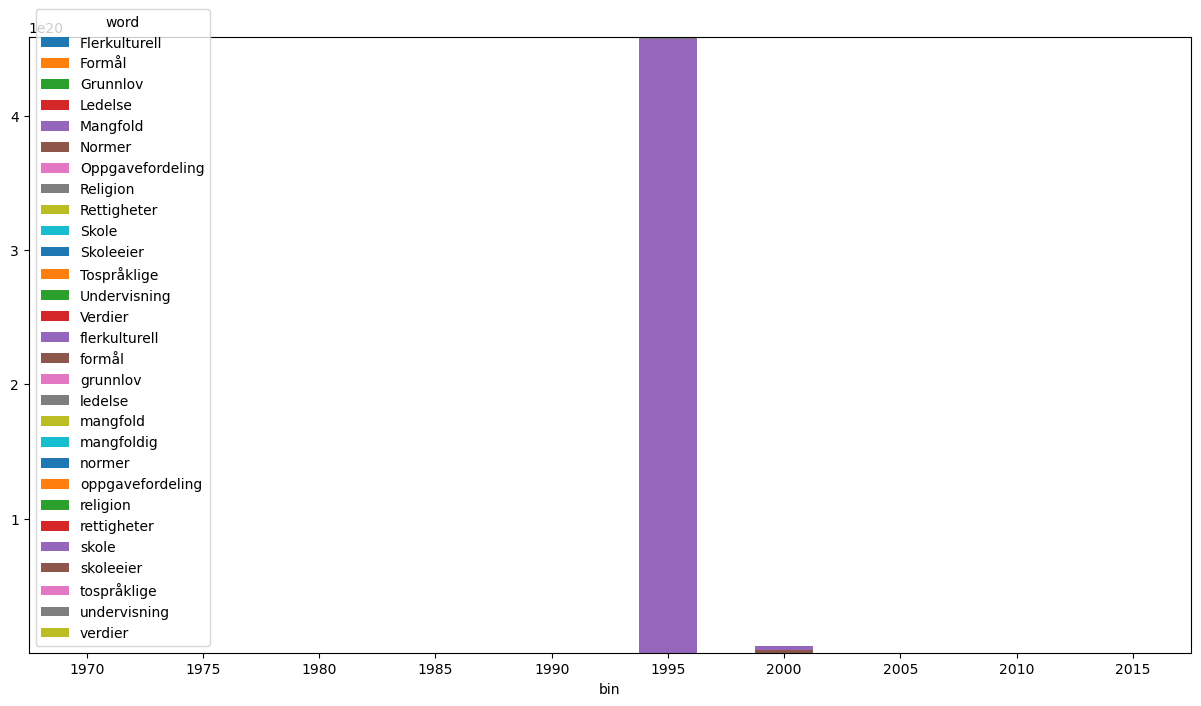

In [536]:
triple = trends.loc[ppt_ord].reset_index()[['word', 'Publication Year', 'frequency']]

df_pivot = triple.pivot(index='Publication Year', columns='word', values='frequency').fillna(0)

df_pivot = df_pivot.apply(pd.to_numeric, errors='coerce')


df0 = df_pivot.reset_index()

df0['Publication Year'] = pd.to_datetime(df0['Publication Year'], format='%Y')

# Create a new 'bin' column to store binned years
df0['bin'] = df0['Publication Year'].dt.year // 5 * 5

# Group by the 'bin' and aggregate by summing up the values
df_binned = df0.groupby('bin').sum().reset_index()

df_binned.set_index('bin').plot(kind='bar', stacked=True, figsize=(15,8), rot=0)

<AxesSubplot: xlabel='Publication Year'>

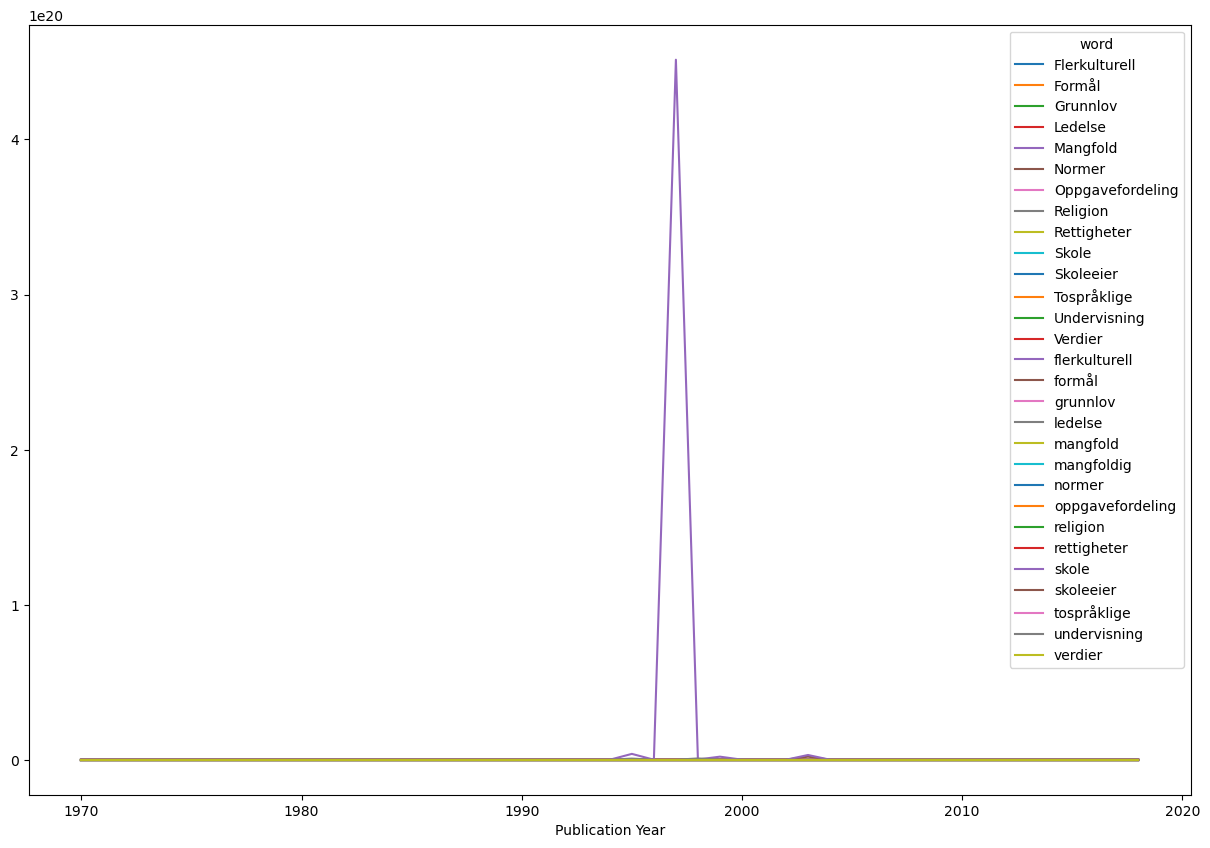

In [527]:
df_pivot.plot()

In [513]:
#df_pivot.groupby(level = "word", axis=1).sum() #.plot(figsize=(10,5))

In [387]:
import dhlab.nbtext as nb

In [388]:
sentral_dok = nb.central_betweenness_characters(G, 10)
mu.printmd('\n\n'.join(["`" + str(round(x[1], 4)) + '`  ' + labels[x[0]] for x in sentral_dok]))
mu.printmd("\n\n--------\n\n")

`0.1462`  NOU 2019: 23 Ny

`0.0858`  NOU 2009: 18 Rett

`0.0815`  NOU 1995: 18 Ny

`0.0766`  NOU 2000: 14 Frihet

`0.0765`  NOU 2018: 15 Kvalifisert,

`0.0704`  NOU 1988: 28 Med

`0.0551`  NOU 1985: 14 Samisk

`0.0551`  NOU 2020: 3 Ny

`0.051`  NOU 1986: 23 Livslang

`0.0505`  NOU 2008: 3 Sett



--------



In [132]:
sentral_dok = nb.central_characters(G, 10)
mu.printmd('\n\n'.join(["`" + str(round(x[1], 4)) + '`  ' + labels[x[0]] for x in sentral_dok]))
mu.printmd("\n\n--------\n\n")

`0.1472`  357    NOU 2019: 23 Ny opplæringslov

`0.1149`  353    NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring

`0.0948`  194    NOU 1995: 18 Ny lovgivning om opplæring "... og for øvrig kan man gjøre som man vil"

`0.0927`  203    NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge

`0.0927`  340    NOU 2009: 18 Rett til læring

`0.0887`  341    NOU 2010: 7 Mangfold og mestring: flerspråklige barn, unge og voksne i opplæringssystemet

`0.0786`  174    NOU 1999: 33 Nyttige lærepenger - om utdanningsfinansiering gjennom Lånekassen

`0.0766`  476    NOU 2003: 16 I første rekke: forsterket kvalitet i en grunnopplæring for alle

`0.0726`  311    NOU 1988: 28 Med viten og vilje

`0.0706`  227    St.meld. nr. 40 (1990—91) Fra visjon til virke Om høgre utdanning



--------



Og her basert på ren sentralitet, de dokumentene som er knyttet til flest andre. Skal samsvare med referansehyppighet. Listen er ganske lik den over.

### Clustring

Selve clustringen ligger i kommandoen `gnl.community_dict`. Nodene, som er nøkler, erstattes av korresponderende tittel. Hvert cluster er ordnet etter sentralitet, det meste sentrale først.

In [219]:
cg = gnl.community_dict(G)
translate = {x:[labels[z] for z in cg[x]] for x in cg}

Overskrift = "## Det er {n}  clustre basert på {d} dokumenter\n\n".format(n = len(cg), d = len(G.nodes()))
rows = '\n\n'.join(["__Cluster "+ str(i + 1) + "__\n\n* " + '\n\n* '.join(translate[x]) for i,x in enumerate(translate)])
mu.printmd(Overskrift + rows)

NameError: name 'gnl' is not defined

In [30]:
for i in cg:
    print(i, len(cg[i]))

3ETZFFNS-7WSWWYHM 46
CC5FSKP9-A4ZPDKMT 2
JQNL2KII-HLGK973Q 78
PY7VZARY-ZBR2P2MG 114
CEDN8EB5-N7T4ZT8C 8
FQTXYHMF-GPFCVH4W 49
A6HRG4JG-V4RID8TN 99
VFE2E59A-DN3YBFQM 26
AD25IKQR-34G9QI8T 20
ERW4A5K3-U8TX647F 11
97Z5KABU-LFLTWJAM 29


VFE2E59A-J7JUTEAB 34
V4RID8TN-3N9XWYFJ 76
HLGK973Q-2CAC6487 57
3ETZFFNS-7WSWWYHM 24
CEDN8EB5-RZQZTZRG 8
DNXZWQYC-33CHN65F 40
JQNL2KII-C4J4FFM6 38
PY7VZARY-3SN7EBSL 109
97Z5KABU-YKFJBKEF 24
A4ZPDKMT-CC5FSKP9 2
ERW4A5K3-U8TX647F 11

In [33]:
import dhlab as dh

In [35]:
tot = dh.totals()

In [61]:
tot.columns = ['tot']

In [62]:
cg.keys()

dict_keys(['3ETZFFNS-7WSWWYHM', 'CC5FSKP9-A4ZPDKMT', 'JQNL2KII-HLGK973Q', 'PY7VZARY-ZBR2P2MG', 'CEDN8EB5-N7T4ZT8C', 'FQTXYHMF-GPFCVH4W', 'A6HRG4JG-V4RID8TN', 'VFE2E59A-DN3YBFQM', 'AD25IKQR-34G9QI8T', 'ERW4A5K3-U8TX647F', '97Z5KABU-LFLTWJAM'])

In [37]:
dtm = pd.concat([co.corpus_text(cg[x], columns = x) for x in cg], axis = 1)

In [38]:
dtm_totals = dtm.sum()

# Basert på antall ord

<Axes: >

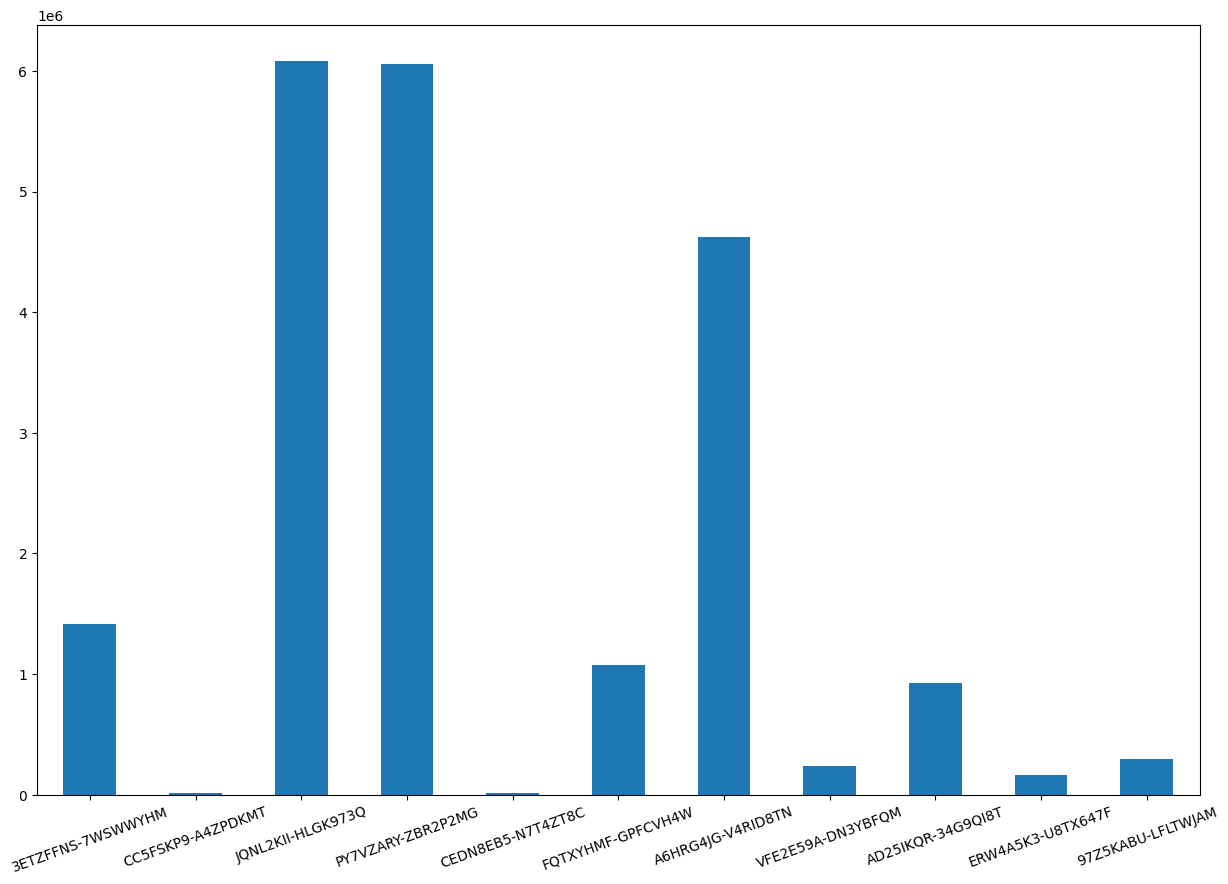

In [39]:
dtm_totals.plot(kind = 'bar', rot=20)

# Antall dokument

<Axes: >

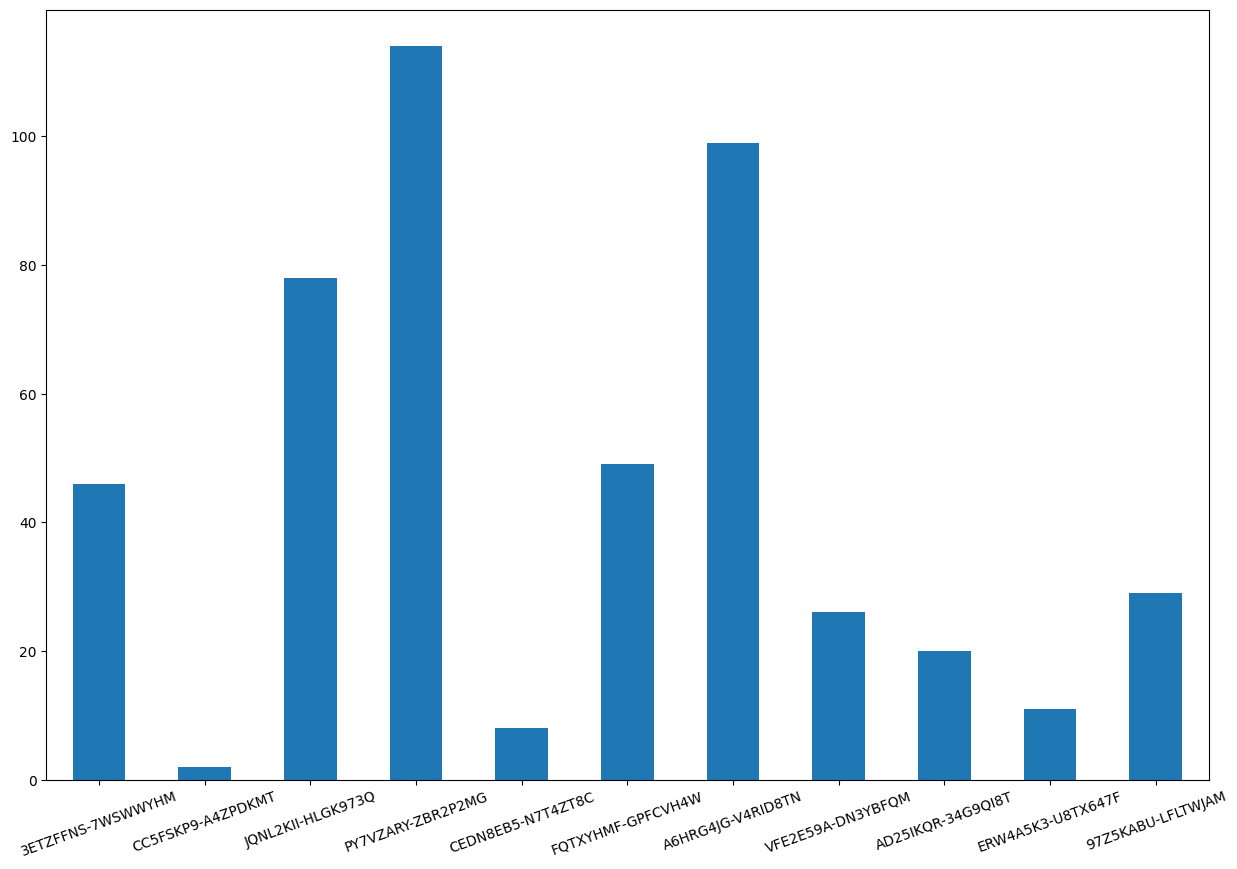

In [40]:
nb.frame(cg).transpose().count().plot(kind='bar', rot = 20)

In [41]:
cg.keys()

dict_keys(['3ETZFFNS-7WSWWYHM', 'CC5FSKP9-A4ZPDKMT', 'JQNL2KII-HLGK973Q', 'PY7VZARY-ZBR2P2MG', 'CEDN8EB5-N7T4ZT8C', 'FQTXYHMF-GPFCVH4W', 'A6HRG4JG-V4RID8TN', 'VFE2E59A-DN3YBFQM', 'AD25IKQR-34G9QI8T', 'ERW4A5K3-U8TX647F', '97Z5KABU-LFLTWJAM'])

In [42]:
# mapping fra forrige
numbering_of_clusters =[x.split() for x in """1 VFE2E59A-TR6PDBUB
2 3N9XWYFJ-ZBR2P2MG
3 JQNL2KII-HLGK973Q
4 V4RID8TN-33CHN65F
5 3ETZFFNS-7WSWWYHM
6 DNXZWQYC-34G9QI8T
7 PY7VZARY-3SN7EBSL
8 HS2MRUCX-V37PB4KM
9 A4ZPDKMT-CC5FSKP9
10 ERW4A5K3-874N6QHD
11 97Z5KABU-LFLTWJAM""".split('\n')]

dict(numbering_of_clusters)

{'1': 'VFE2E59A-TR6PDBUB',
 '2': '3N9XWYFJ-ZBR2P2MG',
 '3': 'JQNL2KII-HLGK973Q',
 '4': 'V4RID8TN-33CHN65F',
 '5': '3ETZFFNS-7WSWWYHM',
 '6': 'DNXZWQYC-34G9QI8T',
 '7': 'PY7VZARY-3SN7EBSL',
 '8': 'HS2MRUCX-V37PB4KM',
 '9': 'A4ZPDKMT-CC5FSKP9',
 '10': 'ERW4A5K3-874N6QHD',
 '11': '97Z5KABU-LFLTWJAM'}

In [43]:
cluster_numbers = dict([(x[1], x[0]) for x in numbering_of_clusters])

In [44]:
numbers = dict([(x[0], list(x[1].split('-'))) for x in numbering_of_clusters])

In [45]:
numbers

{'1': ['VFE2E59A', 'TR6PDBUB'],
 '2': ['3N9XWYFJ', 'ZBR2P2MG'],
 '3': ['JQNL2KII', 'HLGK973Q'],
 '4': ['V4RID8TN', '33CHN65F'],
 '5': ['3ETZFFNS', '7WSWWYHM'],
 '6': ['DNXZWQYC', '34G9QI8T'],
 '7': ['PY7VZARY', '3SN7EBSL'],
 '8': ['HS2MRUCX', 'V37PB4KM'],
 '9': ['A4ZPDKMT', 'CC5FSKP9'],
 '10': ['ERW4A5K3', '874N6QHD'],
 '11': ['97Z5KABU', 'LFLTWJAM']}

In [46]:
cluster_numbers = {x:list(cluster_numbers[x]) for x in cluster_numbers}

In [47]:
for x in cg:
    for y in numbers:
        s = set(cg[x]) & set(numbers[y]) 
        if len(s) >= 1:
            print(x,numbers[y], y, s)

3ETZFFNS-7WSWWYHM ['V4RID8TN', '33CHN65F'] 4 {'33CHN65F'}
3ETZFFNS-7WSWWYHM ['3ETZFFNS', '7WSWWYHM'] 5 {'3ETZFFNS', '7WSWWYHM'}
CC5FSKP9-A4ZPDKMT ['A4ZPDKMT', 'CC5FSKP9'] 9 {'CC5FSKP9', 'A4ZPDKMT'}
JQNL2KII-HLGK973Q ['JQNL2KII', 'HLGK973Q'] 3 {'JQNL2KII', 'HLGK973Q'}
PY7VZARY-ZBR2P2MG ['3N9XWYFJ', 'ZBR2P2MG'] 2 {'ZBR2P2MG'}
PY7VZARY-ZBR2P2MG ['DNXZWQYC', '34G9QI8T'] 6 {'DNXZWQYC'}
PY7VZARY-ZBR2P2MG ['PY7VZARY', '3SN7EBSL'] 7 {'PY7VZARY', '3SN7EBSL'}
PY7VZARY-ZBR2P2MG ['HS2MRUCX', 'V37PB4KM'] 8 {'HS2MRUCX', 'V37PB4KM'}
A6HRG4JG-V4RID8TN ['VFE2E59A', 'TR6PDBUB'] 1 {'TR6PDBUB'}
A6HRG4JG-V4RID8TN ['3N9XWYFJ', 'ZBR2P2MG'] 2 {'3N9XWYFJ'}
A6HRG4JG-V4RID8TN ['V4RID8TN', '33CHN65F'] 4 {'V4RID8TN'}
VFE2E59A-DN3YBFQM ['VFE2E59A', 'TR6PDBUB'] 1 {'VFE2E59A'}
AD25IKQR-34G9QI8T ['DNXZWQYC', '34G9QI8T'] 6 {'34G9QI8T'}
ERW4A5K3-U8TX647F ['ERW4A5K3', '874N6QHD'] 10 {'874N6QHD', 'ERW4A5K3'}
97Z5KABU-LFLTWJAM ['97Z5KABU', 'LFLTWJAM'] 11 {'97Z5KABU', 'LFLTWJAM'}


In [48]:
def check(dictionary, val, default = -1):
    if val in dictionary:
        res = dictionary[val]
    else:
        res = default
    return res
        

In [49]:
list(map(lambda x: check(cluster_numbers,x) , cg.keys()))

[['5'], -1, ['3'], -1, -1, -1, -1, -1, -1, -1, ['1', '1']]

In [50]:
for j,i in enumerate(dtm_totals.index):
    a = i.split('-')
    print(j + 1, i)
    print(ldict[a[0]], ldict[a[1]])
    print()

1 3ETZFFNS-7WSWWYHM
194    NOU 1995: 18 Ny lovgivning om opplæring "... og for øvrig kan man gjøre som man vil" 336    NOU 2007: 11 Studieforbund - læring for livet

2 CC5FSKP9-A4ZPDKMT
53    NOU 1995: 13 Kostnader ved skolestart for seksåringer: utredning fra et utvalg oppnevnt ved kongelig resolusjon 6. mai 1994 ; avgitt til Finans- og tolldepartementet 7. april 1995 216    St.meld. nr. 21 (1996—97) Finansiering av lærebøker for 2. - 10. klassetrinn og status for tilrettelegging av skolelokaler til seksåringer i forbindelse med Reform 97

3 JQNL2KII-HLGK973Q
203    NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge 339    NOU 2008: 3 Sett under ett: ny struktur i høyere utdanning

4 PY7VZARY-ZBR2P2MG
174    NOU 1999: 33 Nyttige lærepenger - om utdanningsfinansiering gjennom Lånekassen 476    NOU 2003: 16 I første rekke: forsterket kvalitet i en grunnopplæring for alle

5 CEDN8EB5-N7T4ZT8C
487    St.meld. nr. 27 (2004-2005) Om opplæringen innenfor kriminalomsorgen

In [51]:
norden = "norge finland sverige danmark norsk norske finsk finske svensk svenske norden nordisk nordiske".split()
norden += [x.capitalize() for x in norden]

In [52]:
norden

['norge',
 'finland',
 'sverige',
 'danmark',
 'norsk',
 'norske',
 'finsk',
 'finske',
 'svensk',
 'svenske',
 'norden',
 'nordisk',
 'nordiske',
 'Norge',
 'Finland',
 'Sverige',
 'Danmark',
 'Norsk',
 'Norske',
 'Finsk',
 'Finske',
 'Svensk',
 'Svenske',
 'Norden',
 'Nordisk',
 'Nordiske']

In [63]:
dtm.sum(axis = 1).sort_values(ascending = False).head(50)

.            0.469507
og           0.329778
,            0.307347
i            0.306629
0            0.205755
for          0.192471
av           0.190026
til          0.169747
er           0.147687
som          0.143392
at           0.116062
å            0.115841
det          0.114968
en           0.101291
med          0.097546
på           0.090620
har          0.083173
de           0.076307
-            0.069716
om           0.066020
)            0.055013
den          0.053194
(            0.050737
et           0.050173
kan          0.046497
:            0.046302
vil          0.044865
1            0.043600
Det          0.041160
ikke         0.040839
fra          0.038906
2            0.038442
I            0.034574
skal         0.034301
eller        0.030221
ved          0.029290
også         0.028885
3            0.025796
være         0.025138
må           0.022613
dette        0.022145
/            0.020920
andre        0.020643
»            0.020549
seg          0.019800
«         

In [54]:
nb.normalize_corpus_dataframe(dtm)

True

In [55]:
ppt_ord = """Grunnlov
Formål
Normer
Verdier
Rettigheter
Flerkulturell
Mangfold
mangfoldig
Religion
Tospråklige
Skole
Skoleeier
Oppgavefordeling
Undervisning
Ledelse
""".split()
ppt_ord += [x.lower() for x in ppt_ord]
ppt_ord = list(set(ppt_ord))

In [56]:
ppt_ord

['Tospråklige',
 'formål',
 'mangfoldig',
 'skole',
 'flerkulturell',
 'Skoleeier',
 'grunnlov',
 'ledelse',
 'Mangfold',
 'Formål',
 'Religion',
 'skoleeier',
 'oppgavefordeling',
 'Undervisning',
 'undervisning',
 'verdier',
 'Skole',
 'normer',
 'rettigheter',
 'Normer',
 'Flerkulturell',
 'Verdier',
 'Ledelse',
 'tospråklige',
 'mangfold',
 'Oppgavefordeling',
 'Rettigheter',
 'Grunnlov',
 'religion']

In [64]:
(dtm.loc[[x for x in ppt_ord if x in dtm.index]]*100000).fillna(0).style.background_gradient(axis = 1)

,3ETZFFNS-7WSWWYHM,CC5FSKP9-A4ZPDKMT,JQNL2KII-HLGK973Q,PY7VZARY-ZBR2P2MG,CEDN8EB5-N7T4ZT8C,FQTXYHMF-GPFCVH4W,A6HRG4JG-V4RID8TN,VFE2E59A-DN3YBFQM,AD25IKQR-34G9QI8T,ERW4A5K3-U8TX647F,97Z5KABU-LFLTWJAM
Tospråklige,0.000000,0.000000,0.000000,0.346611,0.000000,0.186493,0.238125,0.000000,0.108406,0.000000,0.000000
formål,25.708266,0.000000,20.513512,10.480865,20.262056,11.562580,13.767977,7.473376,32.955430,15.001590,16.369403
mangfoldig,0.282508,0.000000,0.740263,0.990318,0.000000,1.864932,2.229720,2.075938,1.842902,1.200127,0.000000
skole,135.462788,16.842105,21.681483,83.302248,216.128597,18.183090,59.249927,20.759378,72.198409,0.600064,131.637281
flerkulturell,0.070627,0.000000,0.822515,0.445643,0.000000,0.559480,2.879152,1.245563,0.650436,0.000000,0.000000
Skoleeier,0.000000,0.000000,0.016450,0.115537,20.262056,0.093247,1.039093,0.000000,0.000000,0.000000,0.341029
grunnlov,0.706271,0.000000,1.677930,0.231074,0.000000,0.000000,0.216478,0.000000,0.216812,0.000000,0.341029
ledelse,6.215185,0.000000,15.923881,10.678929,0.000000,15.478938,8.009672,12.870814,4.011023,6.000636,2.046175
Mangfold,0.070627,0.000000,0.460608,0.082526,0.000000,1.025713,14.504001,0.000000,0.542030,0.600064,0.341029
Formål,0.565017,0.000000,0.394807,0.264085,0.000000,1.118959,0.757672,0.415188,9.431324,0.000000,0.341029


In [58]:
(dtm.loc[[x for x in "opplæring tilpasset grunnloven grunnlov rettigheter spesialundervisning".split() if x in dtm.index]]*1000000).fillna(0).style.background_gradient(axis = 1)

,3ETZFFNS-7WSWWYHM,CC5FSKP9-A4ZPDKMT,JQNL2KII-HLGK973Q,PY7VZARY-ZBR2P2MG,CEDN8EB5-N7T4ZT8C,FQTXYHMF-GPFCVH4W,A6HRG4JG-V4RID8TN,VFE2E59A-DN3YBFQM,AD25IKQR-34G9QI8T,ERW4A5K3-U8TX647F,97Z5KABU-LFLTWJAM
opplæring,2654.166611,0.000000,314.858560,786.642591,10266.108334,553.884887,1260.332748,817.919495,1020.100644,78.008269,1428.912458
tilpasset,150.435734,1010.526316,99.688761,104.973707,1283.263542,104.436208,241.372555,161.923149,153.936548,54.005725,61.385261
grunnloven,15.537963,0.000000,28.623505,0.990318,67.540186,0.000000,4.762508,0.000000,18.429023,0.000000,0.000000
grunnlov,7.062711,0.000000,16.779296,2.310742,0.000000,0.000000,2.164776,0.000000,2.168120,0.000000,3.410292
rettigheter,280.389607,0.000000,293.637686,61.729821,337.700932,218.197077,314.325515,149.467522,146.348126,18.001908,364.901272
spesialundervisning,470.376520,0.000000,5.099590,18.816042,135.080373,2.797398,153.049683,0.000000,53.118950,0.000000,88.667599


In [66]:
mu.printmd( "## De viktigste ordene i hvert cluster\n\n".format(n = len(cg), d = len(G.nodes())))


for x in cg:
    #mu.printmd(x)
    translate = [labels[z] for z in cg[x][:10]]
    mu.printmd('### Topp rapporter')
    mu.printmd(f"*{', '.join(translate)}*")
    mu.printmd('\n\n')
    rows = ', '.join(
        (
            co.corpus_text(cg[x])['freq']/tot['tot']
        ).sort_values(
            ascending = False
        )[:130].index
    )
    mu.printmd('#### Viktigste ord')
    mu.printmd(rows)



## De viktigste ordene i hvert cluster



### Topp rapporter

*194    NOU 1995: 18 Ny lovgivning om opplæring "... og for øvrig kan man gjøre som man vil", 336    NOU 2007: 11 Studieforbund - læring for livet, 495    St.meld. nr. 54 (1989-90) Om opplæring av barn, unge og voksne med særskilte behov., 394    St.meld. nr. 23 (1997—98) Om opplæring for barn, unge og vaksne med særskilde behov Den spesialpedagogiske tiltakskjeda og det statlege støttesystemet, 223    St.meld. nr. 35 (1990—91) Tillegg til St.meld. nr. 54 (1989—90) Om opplæring av barn, unge og voksne med særskilte behov, 215    St.meld. nr. 20 (2000-2001) Om korte yrkesrettede utdanninger etter videregående opplæring, 276    St.meld. nr. 12 (2006-2007) Regionale fortrinn – regional framtid, 197    NOU 1997: 16 Tilskuddssystemet for private skoler, 401    St.meld. nr. 61 (1984-85) Om visse sider ved spesialundervisninga og den pedagogisk-psykologiske tenesta, 480    St.meld. nr. 14 (2003-2004) Om opplæringstilbod for hørselshemma*

#### Viktigste ord

Utvalgets, spesialundervisning, oppl, St.meld, NOU, tenesta, lovverket, lovgivning, utvalgets, statlege, arbeids, enkeltvedtak, forvaltningsloven, utdannings-, funksjonshemma, arbeidsmiljøloven, regionene, Utvalget, kompetansesenter, fylkeskommuner, virksomhetene, grunnskole, opplæring, lovgivningen, Vedlegg, Innstilling, regulerer, vidaregåande, arbeidstaker, opplæringen, partementet, forskrifter, voksenopplæring, lov-, særskilte, opplæringa, elevar, lovbestemmelser, fastsetter, sentre, grunnskolen, forskriften, arbeidstakeren, fylkeskommunene, arbeidstakerne, Ot.prp, lovene, regional, mentet, fyl, fortrinn, tilpassa, læremidler, opphevelse, Innst, Lov, oppheves, tilsatte, forskrift, skoleverket, kommunesektoren, skular, fylkeskommunal, meld, fagleg, struktur, sentra, regionalt, likeverdig, hjemmel, forarbeidene, institusjonar, gjennomgåelse, Loven, nale, nr, statstilskudd, vens, Lovens, Departementet, videreføres, fagskole, brukarar, elevens, arbeidsmiljø, virkeområde, Kapittel, inntak, emosjonelle, beid, regionale, læring, inndeling, regioner, lønnsomt, nærmare, barken, kunn, lovs, Bestemmelsen, Gjeldende, stu, oppsigelsen, fastsette, faglege, fastsettes, arbeidsmiljøet, lese-, oppsigelse, vanskar, tilskot, samordning, mandatet, tenester, pkt, Arbeids-, prp, hjemlet, fortrinnsrett, ressursar, fylkeskommunale, Omfanget, somhet, jf., etterutdanning, videreført, lovfestet, virksomhetens, voksnes, bestemmelsen

### Topp rapporter

*53    NOU 1995: 13 Kostnader ved skolestart for seksåringer: utredning fra et utvalg oppnevnt ved kongelig resolusjon 6. mai 1994 ; avgitt til Finans- og tolldepartementet 7. april 1995, 216    St.meld. nr. 21 (1996—97) Finansiering av lærebøker for 2. - 10. klassetrinn og status for tilrettelegging av skolelokaler til seksåringer i forbindelse med Reform 97*

#### Viktigste ord

ant, lærebøker, klassetrinn, skolestart, Reform, tot, meld, tilrettelegging, Finansiering, utdannings-, kommuneøkonomien, lokaler, Innst, utskifting, utløser, innsparing, prp, 0, mill, 1997, 1997., utbygd, midlertidige, klasserom, Kostnader, status, ging, påbegynt, nasjonalbudsjett, 1996, Status, Kommunene, arbei, framdrift, kommunenes, klasser, Kommune, klassene, mid, oppgir, Bakgrunn, mentet, ringene, mune, redegjort, tilpasset, Godkjenning, 1742, partementet, 2022, 1743, 1711, 1420, m.a.o., Asnes, rapportert, spørreundersøkelse, Kommunenes, 1739, Rade, tilpasses, Kirke-, 1665, Utgiftene, presiseres, permanente, Agdenes, 1525, Alesund, byggearbeider, dert, Audnedal, Songdalen, kommunene, Roan, utdypet, overføringene, ordi, gene, Amot, stre, Skjema, nr, Gaular, iverksettes, 97, rap, Solund, hhv., tart, årskull, 532, Modalen, tilpassing, tilpasninger, kro, forutsette, Tustna, Norddal, innhentet, FINANSIERING, forskyvning, akseptable, driftskostnader, 2025, læ, avklart, Hoi, ferdige, Departementets, 1120, 1520, merknad, pkt, sek, Re, spørreskjema, byggestart, Lokaler, 1751, Vanylven, 1725, forutsettes, Bokn, statsbudsjettet, Marnardal, 1755, mht., Gjemnes, Tjeldsund

### Topp rapporter

*203    NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge, 339    NOU 2008: 3 Sett under ett: ny struktur i høyere utdanning, 186    St.meld. nr. 27 (2000-2001) Gjør din plikt - Krev din rett Kvalitetsreform av høyere utdanning, 181    St.meld. nr. 42 (1997-98) Kompetansereformen, 481    St.meld. nr. 16 (2001-2002) Kvalitetsreformen Om ny lærerutdanning Mangforldig - Krevende - relevant, 179    St.meld. nr. 36 (1998-99) Om prinsipper for dimensjonering av høgre utdanning, 172    NOU 1997: 25 Ny kompetanse Grunnlaget for en helhetlig etter- og videreutdanningspolitikk, 389    St.meld. nr. 7 (2007-2008) Statusrapport for Kvalitetsreformen  i høgre utdanning, 477    NOU 2003: 25 Ny lov om universiteter og høyskoler, 180    St.meld. nr. 39 (1997-98) Om dimensjonering av ulike studier innenfor høgre utdanning*

#### Viktigste ord

funksjonsevne, samenes, ært, NOU, ogs, institusjonene, St.meld, høyskoler, universitets-, samiske, oppl, Utvalgets, høgskoler, utdannings-, universitetene, universiteter, universell, forskningsråd, Frihet, ørt, utvalgets, meld, forsknings-, ærer, spr, øring, Utvalget, diskriminering, samer, forsk, ått, kompetanseutvikling, samene, Sametinget, misk, tilgjengelighet, funksjonshemma, museene, omr, danning, næ, SND, OECD, mrd., nale, Sosial-, Samisk, Kapittel, vikling, indikatorer, lærerutdanning, etter-, virksomhetene, reindrift, øres, fullmakter, arbeids, Innst, Vedlegg, Forskning, barrierer, forskning, likeverd, BNP, minoriteter, videreutdanning, fyl, samfunns, somhet, partementet, innovasjon, eksternt, tjenesteyting, øer, forskningen, mentet, bedriftenes, ressursbruk, studiekompetanse, utdanningen, vekttall, statlige, arbeidsdeling, samfunns-, ål, konvensjon, institusjonen, utviklingsarbeid, sektoren, mobilitet, virkemidlene, kunn, sam, øp, etnisk, utdanning, Tiltak, evalueringen, Organisering, samisk, fagområder, NSR, virksomhetens, etterutdanning, gjen, nom, ordningene, pst, stu, verdiskaping, sysselsetting, fagfelt, utkastet, Nærings-, Samiske, rammebetingelser, konvensjonen, prioriteringer, utforming, arbeidsstyrken, tilrettelegging, næringene, informasjons-, statlig, gets, høgre, avkastningen, institusjoner, evaluering, beid

### Topp rapporter

*174    NOU 1999: 33 Nyttige lærepenger - om utdanningsfinansiering gjennom Lånekassen, 476    NOU 2003: 16 I første rekke: forsterket kvalitet i en grunnopplæring for alle, 311    NOU 1988: 28 Med viten og vilje, 227    St.meld. nr. 40 (1990—91) Fra visjon til virke Om høgre utdanning, 170    NOU 1991: 4 Veien videre : til studie - og yrkeskompetanse for alle, 225    St.meld. nr. 37 (1990—91) Om organisering og styring i utdanningssektoren, 228    St.meld. nr. 40 (1992—93) ... vi smaa, en Alen lange; Om 6-åringer i skolen - konsekvenser for skoleløpet og retningslinjer for dets innhold, 165    NOU 1986: 23 Livslang læring, 314    NOU 1989: 13 Grenseløs læring mottak av utenlandske studenter, studentutveksling og internasjonalisering, 184    NOU 1993: 24 Lov om universiteter og høgskoler*

#### Viktigste ord

St.meld, høgskoler, NOU, stu, danning, ært, Utvalgets, Lånekassen, verdiskaping, forsk, partementet, lærerutdanning, utdannings-, meld, ogs, Utvalget, Utgifter, gymnaset, studiekompetanse, barnetrygden, oppl, Vedlegg, barnefamilier, universitets-, utdanningen, mentet, utvalgets, universitetene, høyskoler, universiteter, Reform, vekttall, studieretning, førstekonsulent, forsørgere, skoleverket, etterutdanning, SUM, Tilskudd, misk, nale, institusjonene, opplæringen, ørt, Kultur-, høgre, arbeids, ærer, samfunns, Organisering, høgskole, fag-, differensiering, overføringer, studentenes, vikling, gjen, forskningsråd, barnetrygd, næ, kunn, OECD, samiske, grunnskole, utdanning, stipend, Forbruker-, ått, utviklingsarbeid, allmenne, BNP, NTNU, sam, fag, førskolelærere, fagene, læring, sysselsetting, fyl, studietiden, grunnskolen, utgår, Offentlige, ordningene, gym, beid, husholdningene, arbeidsdeling, grunnkurs, administrasjonsdepartementet, voksenopplæring, tilsatte, fakultet, fagområder, underdirektør, fordypning, forsknings-, 1986, kulturarv, sektorer, nom, uni, videreutdanning, eksamener, mobilitet, Idretten, øring, overf, fylkeskommunene, utvalet, elevane, undervisninga, vendig, fagområde, ån, arkiver, yrkesopplæring, pedagogiske, studenter, pro, helsetjeneste, Innst, Departementet, ningene, departementene, Universitetsbiblioteket, ungdomstrinnet, opplæring, hovedfag, allment

### Topp rapporter

*487    St.meld. nr. 27 (2004-2005) Om opplæringen innenfor kriminalomsorgen “Enda en vår”, 284    St.meld. nr. 23 (2003-2004) Om boligpolitikken, 131    St.meld. nr. 27 (1997-98) Om kriminalomsorgen, 118    NOU 1988: 39 Politi og påtalemyndighet:arbeids- og ansvarsfordeling : utredning fra et utvalg oppnevnt ved kongelig resolusjon av 16. januar 1987 : avgitt til Justis- og politidepartementet november 1988, 117    NOU 1981: 35 Politiets rolle i samfunnet:delutredning I, 119    NOU 1991: 29 Lensmannsetatens oppgaver og organisering:utredning fra et utvalg oppnevnt av Justis- og politidepartementet ved brev av 20. juni 1990 : avgitt til [sic] 27. juni 1991, 132    NOU 1987: 27 Politiets rolle og oppgaver i samfunnet: delutredning II, 129    St.meld. nr. 23 (1991-92) Om bekjempelse av kriminalitet*

#### Viktigste ord

innsatte, fengslene, St.meld, opplæringen, Departementets, fengsler, domfelte, opplæring, Aetat, fengslet, visningen, IKT, forekomsten, studiekompetanse, enkeltvedtak, lærernes, mv., oppfølgingen, avbrudd, utdannings-, evalueringen, bibliotekene, etatene, hjemlet, utlendinger, læring, vurderinger, 2003, videreføre, frafall, Opplæring, lese-, 2004, Innst, samfunns-, danning, målgruppen, Modeller, fengsel, rere, skoleverket, kriminaliteten, tilpasset, sorgen, Evaluering, Organisering, omsorgen, etater, nedfelt, mangelfull, utdanning, Justisdepartementet, føring, voksnes, overføringer, høyskole, skoletilbud, Oppfølging, kontinuitet, føringer, murene, samfunnsøkonomisk, Innholdet, minoriteter, telse, videreføres, messig, statsborgerskap, samsvarer, Prinsippet, samordning, Rapporten, innretning, Bakgrunn, instruktører, rehabilitering, fullført, tilbudene, kapitlene, mestring, vektlegges, kriminalitet, Skolene, spesialundervisning, tredel, fremheves, enkeltes, koordinering, motivasjon, beid, yrkesopplæring, prøveprosjekt, lighet, gjennomgås, partementet, ankret, bidragsyter, Andelen, lovgivningen, anstalt, bekjempelse, selvbilde, ...................., Skole-, forpliktelsene, tilbakefall, ressursbruk, likestilt, lov-, verkstedene, rapporterer, instanser, styrking, rammevilkår, motiverende, Fleksibel, fes, universitets-, renovering, grunnskole, skolenes, tilsatte, innvandrere, Ulike, ferier, Aktiviteter, likeverdig, Sandvik, dert, avbryter

### Topp rapporter

*353    NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring, 361    NOU 2020: 3 Ny lov om universiteter og høyskoler, 352    NOU 2018: 13 Voksne i grunnskole- og videregående opplæring Finansiering av livsopphold, 391    St.meld. nr. 9 (2016–2017) Fagfolk for fremtiden Fagskoleutdanning, 370    St.meld. nr. 16 (2016–2017) Kultur for kvalitet i høyere utdanning, 384    St.meld. nr. 4 (2018–2019) Langtidsplan for forskning og høyere utdanning 2019 - 2028, 351    NOU 2016: 7 Norge i omstilling - karrierveiledning for individ og samfunn, 369    St.meld. nr. 16 (2015–2016) Fra utenforskap til ny sjanse Samordnet innsats for voksnes læring, 366    St.meld. nr. 14 (2019–2020) Kompetansereformen - Lære hele livet, 374    St.meld. nr. 18 (2014-2015) Konsentrasjon for kvalitet Strukturreform i universitets- og høyskolesektoren*

#### Viktigste ord

OECD, Meld, NOU, utdannings-, finanser, innvandrere, universitets-, NAV, høyskoler, partnerskap, mfl., vendepunkt, J., fag-, BNP, Arbeids-, innvandring, verdiskaping, Fagfolk, digital, Fremtidens, tjenestene, omstilling, nale, veiledere, innovasjon, utdanningen, danning, arbeidsmarkedet, frafall, ordningene, Nasjonalt, services, Education, innvandrerne, produktivitet, Utvalgets, utvalgets, mobilitet, høy-, universiteter, samar-, G., mottakere, yrkes-, IKT, ytelser, 2016, Utvalget, bru-, ressursbruk, sammen-, universitetene, helse-, nettstedet, arbeidsevne, studentenes, kere, anskaffelser, 2015, fagfelt, handlingsrom, digitale, tiårene, Prosent, ningene, kontantstøtte, helhetlig, St.meld, anslås, produktiviteten, https, alderspensjon, arbeids-, samfunns-, levealder, EØS, M., uførepensjon, tjenesteyting, indikatorer, Kapittel, sentre, Economic, andelen, individ, nom, mrd., 2014, helsetjenester, arbeidsmarked, sentralbyrå, Kompetanse, sektoren, finanskrisen, arbeidslivet, arbeidsstyrken, sosialhjelp, oppfølgingen, utdanning, O., ...................., koordinering, anbefalinger, misk, sering, sektor, virksomhetene, Andelen, brukernes, relevans, Canadian, ging, R., kommu-, Working, m.fl, institusjonene, utvik-, sysselsetting, folketrygden, Tilgang, gjennom-, sysselsatte, dagpenger, partementet, arbeidskraften, 2013, kompetanse, P.

### Topp rapporter

*357    NOU 2019: 23 Ny opplæringslov, 340    NOU 2009: 18 Rett til læring, 341    NOU 2010: 7 Mangfold og mestring: flerspråklige barn, unge og voksne i opplæringssystemet, 347    NOU 2014: 7 Elevenes læring i fremtidens skole Et kunnskapsgrunnlag, 344    NOU 2012: 1 Til barnas beste Ny lovgivning for barnehagene, 488    St.meld. nr. 30 (2003-2004) Kultur for læring, 349    NOU 2015: 8 Fremtidens skole Fornyelse av fag og kompetanser, 348    NOU 2015: 2 Å høre til Virkemidler for et trygt psykososialt miljø, 368    St.meld. nr. 16 (2006-2007) ... og ingen sto igjen Tidlig innsats for livslang læring, 365    St.meld. nr. 14 (2008-2009) Internasjonalisering av utdanning*

#### Viktigste ord

St.meld, NOU, kommunesektoren, Utvalgets, Sametinget, opplæringen, fyl, nale, mfl., Utvalget, spesialundervisning, funksjonsevne, arbeidsmiljøloven, utvalgets, fylkeskommunene, læremidler, mestring, Arbeids-, sosial-, fylkeskommuner, arbeidstaker, fag-, kompetanseutvikling, handlingsrom, minoriteter, diskriminering, J., enkeltvedtak, frafall, Kapittel, samiske, likestilling, utdannings-, OECD, ressursbruk, innvandrere, arbeidstakerne, barnehagens, læring, virksomhetene, nene, førskolelærere, morsmål, likeverdig, tilsyn, †, tilsynet, evalueringen, språklige, grunnskole, elevenes, inkluderende, trakassering, jf., studiekompetanse, direktivet, regionalt, ungdomstrinnet, opplæring, Meld, tjenestetilbud, læreplanen, indikatorer, virk-, Sosial-, helsetjenester, helhetlig, elevens, tjenestene, mandatet, statlig, arbeidsmarkedet, Andelen, kommunenes, kvin, samordning, fordypning, ging, Politikk, regionale, barrierer, ært, partementet, oppfølgingen, Ot.prp, PPT, Evaluering, ivaretas, regional, helsehjelp, barnehagene, timelønn, Aetat, sosialtjenesten, barnehager, ordningene, sering, tilgjengelighet, grunnskolen, videreføres, valgfrihet, målgruppen, Vedlegg, statlige, høyskoler, Kommunene, Tilsyn, kjønnene, arbeidstakeren, føringer, beid, sektoren, universitets-, 2008, etnisk, arbeidsliv, lov-, arbeidslivet, Innst, mv., Organisering, arbeidstakere, rettssikkerhet, sektorer, vikling, Departementets, arbeidsgiver, lærlinger, mentet, Sundnes

### Topp rapporter

*364    St.meld. nr. 13 (2011–2012) Utdanning for velferd Samspill i praksis, 373    St.meld. nr. 18 (2012–2013) Lange linjer  – kunnskap gir muligheter, 382    St.meld. nr. 30 (2008-2009) Klima for forskning, 332    St.meld. nr. 39 (2006-2007) Frivillighet for alle, 277    St.meld. nr. 15 (2000-2001) Nasjonale minoritetar i Noreg - Om statleg politikk overfor jødar, kvener, rom, romanifolket og skogfinnar, 31    NOU 2009: 08 Kompetanseutvikling i barnevernet Kvalifisering til arbeid i barnevernet gjennom praksisnær og forskningsbasert utdanning, 430    St.meld. nr. 7 (2008-2009) Et nyskapende og bærekraftig Norge, 89    NOU 2005: 3 Fra stykkevis til helt En sammenhengende helsetjeneste, 101    St.meld. nr. 25 (2005-2006) Mestring, muligheter og mening. Framtidas omsorgsutfordringer, 442    NOU 1998: 9 Hvis det haster..... Faglige krav til akuttmedisinsk beredskap*

#### Viktigste ord

samhandling, St.meld, helsetjenesten, tjenestene, funksjonsevne, tjenestetilbud, sosialfag, Utvalgets, Utdanning, Sosial-, helse-, Meld, omsorgsboliger, pleie-, demens, †, NOU, Utvalget, velferd, sosialtjenesten, nale, helsetjenester, fastlege, framtidas, 2050, kullet, Helse-, brukernes, sosial-, individuell, sysselsatt, helsepersonell, utdannings-, tverrfaglig, helsehjelp, helsevern, understøtte, pasientenes, kommunesektoren, levealder, fag-, sykehjemmene, forskningsråd, sammensatte, helsetjeneste, Nasjonalt, yrkes-, framtidens, høyskoler, helhetlig, 2030, somatiske, utvalgets, forebygging, personell, tilgjengelighet, utviklingsarbeid, sektoren, samar-, studiekompetanse, pasientens, universitets-, helsetilstand, årsverk, brukere, 2005, Kull, Arbeids-, kompetansen, Kommunene, 2025, rehabilitering, oppfølgingen, ordningene, ningene, hjelpeapparatet, organisatoriske, SSB, foretak, nene, sykehjem, utdanningen, institusjonene, sentre, kroniske, pasienter, J., tjenester, interkommunalt, Andelen, barnevernet, ging, autorisasjon, universitetene, sykehjemsplasser, avtalene, ressursbruk, innleggelse, arbeidsdeling, treårig, nyutdannede, regionale, mulig-, kvalitativt, legevakt, barrierer, spesialisering, bru-, vel-, pasientene, koordinert, brukerne, enter, rettssikkerhet, opplæringen, Pasienter, stortingsmeldingen, partementet, Kapittel, Økonomiske, universell, Aetat, yrkesgrupper, interkommunale, utfordringene, forsknings-, rammebetingelser, serte, folkehelse, kliniske

### Topp rapporter

*337    NOU 2007: 6 Formål for framtida: formål for barnehagen og opplæringen, 220    St.meld. nr. 29 (1994-95) Om prinsipper og retningslinjer for 10-årig grunnskole - ny læreplan, 177    St.meld. nr. 28 (1998-99) Mot rikare mål Om einskapsskolen, det likeverdige opplæringstilbodet og ein nasjonal strategi for vurdering og kvalitetsutvikling i grunnskolen og den vidaregåande opplæringa, 176    St.meld. nr. 25 (1998-99) Morsmålsopplæring i grunnskolen, 393    St.meld. nr. 14 (1997-98) Om foreldremedverknad i grunnskolen, 171    NOU 1995: 9 Identitet og dialog Kristendomskunnskap, livssynskunnskap og religionsundervisning, 187    St.meld. nr. 32 (2000-2001) Evaluering av faget Kristendomskunnskap med religions- og livssynsorientering, 231    St.meld. nr. 47 (1995-96) Om elevvurdering, skolebasert vurdering og nasjonalt vurderingssystem, 246    St.meld. nr. 23 (1992—93) Om forholdet mellom staten og kommunane, 211    St.meld. nr. 14 (1995–96) Om kristendomskunnskap med religions og livssynsorientering*

#### Viktigste ord

St.meld, opplæringa, trossamfunn, fritak, statlege, Utvalgets, barnehagens, religioner, kir, læreplanen, grunnskolen, minoriteter, kommunane, opplæringen, NOU, livssyn, Evaluering, valgmuligheter, grunnskole, oppl, faget, fellesråd, Innst, kirkelig, meld, ungdomstrinnet, foreldra, Grunnlovens, utdannings-, språklige, BNP, kommunar, Barnehagen, Faget, humanistiske, ressursbruk, ært, Formål, kommunesektoren, kriterium, fagene, innbyggjarar, Utvalget, ogs, fyl, kirkelige, mål-, videreføres, finanser, rettleiing, utvalet, undervisninga, måla, Kirkelig, ressursar, morsmål, Grunnloven, verneverdige, tilskot, nale, morsmålet, barnehagen, innverknad, faglege, Departementet, klassetrinn, vikling, Sejersted, mentet, formålsparagraf, partementet, overordna, tilpassa, livs-, einskilde, utvalgets, kirkes, ærer, etterutdanning, Sandvig, elevenes, endringar, barne, resultata, Regjeringa, òg, Kapittel, intensjonene, inneber, utformes, likeverd, kirkens, likeverdig, religion, misk, elevane, utviklingsarbeid, nom, innafor, danning, kulturarv, oppheves, meldinga, humanistisk, pst, fag-, handlingsrom, oppdragelse, mandatet, læring, levealder, skatteinntekter, leggje, etikk, omtala, læremidler, gjen, evalueringen, lov-, Vedlegg, kirkesamfunn, fagleg, kens, dialog, døpte, kristendommen, vidaregåande, forståing, øse, elevar

### Topp rapporter

*320    St.meld. nr. 24 (1994—95) Nærkringkasting, 321    St.meld. nr. 26 (1991-92) Kringkasting og dagspresse 1990 m.v., 327    St.meld. nr. 42 (1993-94) Kringkasting og dagspresse 1993 m.v., 330    NOU 1992: 14 Mål og midler i pressepolitikken: utredning fra et utvalg oppnevnt ved kongelig resolusjon 15. februar 1991 ; avgitt til Kulturdepartementet 5. mai 1992, 324    St.meld. nr. 32 (1992-93) Media i tida, 312    NOU 1984: 5 Kringkastingsreklame: forslag til finansiering av et utvidet kringkastingstilbud, 137    NOU 1975: 7 Kringkastingslov, 297    NOU 1982: 33 Nærradio, 325    St.meld. nr. 39 (1990-91) Virksomheten i Norsk rikskringkasting m.v., 308    St.meld. nr. 88 (1981-82) Om medieutvikling og nye kringkastingsformer*

#### Viktigste ord

sendetid, meld, frekvens, Vedlegg, konsesjoner, sendingene, kommersielle, dio, dinger, St.meld, rammevilkår, lyttere, Kulturdepartementet, satellitt, kommersiell, kringkasting, reklame, udvikling, konsesjonen, lokal-, konkurser, 1994, bingo, stasjonene, frekvensen, tilladelse, virksomhed, TVN, Konklusjon, tilladt, Nemnda, rammebetingelser, riks, gennem, BI, TVNorge, NFL, levedyktig, kabel, europæiske, omsætning, kon, markedsandel, Kommissionen, 1993, nemndas, udstedt, kommersielt, konsesjon, pro, lytterne, stasjoner, investorer, inneha, Departementets, kende, seere, Kommuner, samsending, tildele, 1992, Media, MMI, Nettverk, egenkapital, partementet, selskab, Gjennomsnittlig, Prosentvis, somhet, slutningen, konkurs, kanal, hovedregel, Ot.prp, senderen, nale, Omfang, tilfældet, eter, Kostnader, mht., eds, begrænset, onene, misk, enerett, erne, vikling, signifikant, TV-, markedsandeler, Lokal-TV, Inn-, udgjorde, sket, Kanal, centrale, lokal, radio-, bransjen, Radioen, aktører, redegjør, nemnda, 1993., variabler, mentet, kanalene, gjen, aktørene, ideelle, Innst, udviklet, seneste, skapene, lytter, Finmark, allmenn, DAB, indtægter, sam, stør, hævder, Lokalradio, lertid, specielt, signalene, speciel, arbejde

### Topp rapporter

*298    NOU 1985: 14 Samisk kultur og utdanning, 232    St.meld. nr. 51 (1988-89) I tillegg til St.meld. nr. 45 for 1987-1988 Om forskning, forsøk og utviklingsarbeid i opplæringa, 151    St.meld. nr. 39 (1983-84) DATATEKNOLOGI I SKOLEN, 185    St.meld. nr. 24 (1993-94) Om informasjonsteknologi i utdanningen : rapport fra handlingsprogrammet 1990-93 og strategi for videre arbeid, 209    St.meld. nr. 14 (1989-90) Informasjonsteknologi i skole og opplæring, 224    St.meld. nr. 37 (1987-88) Om datateknologi i skole og opplæring, 397    St.meld. nr. 45 (1987—88) Om forsking, forsøk og utviklingsarbeid i opplæringa, 201    St.meld. nr. 79 (1983-84) Om det pedagogiske utviklingsarbeidet i skolen og om forsøksvirksomheten i skoleverket skoleårene 1981—82 og 1982-83 (FoU-meldingen), 493    St.meld. nr. 42 (1989—90) Organisering av informasjonsteknologi i skole og opplæring Tillegg til St.meld. nr 14 (1989-90) Informasjonsteknologi i skole og opplæring, 144    NOU 1982: 27 Funksjonsfordeling og administrasjonsordninger*

#### Viktigste ord

samenes, misk, samiske, samene, samer, St.meld, Samisk, programvare, NOU, utviklingsarbeid, samisk, tellingen, Samiske, morsmål, skoleverket, morsmålet, reindrift, språklige, læremidler, opplæringa, etterutdanning, partementet, utdanningen, NSR, etnisk, utarbeiding, IT, meld, databaser, høgskoler, språklig, Nesseby, lærerutdanning, etniske, dialekter, forsking, Utvalgets, utvalgets, grunnskolen, husflid, språk, rådene, egenart, Organisering, mentet, Språket, vikling, fyl, minoritet, kulturell, Innst, kulturarv, livsform, utprøving, grunnskole, skriftspråk, næ, bosettingen, Karasjok, maste, kultur-, irsk, stedsnavn, fagområder, bosetting, språkbruk, lende, folketellingen, bærere, integrering, kultur, Utvalget, språket, Kultur-, utdannings-, grunnsyn, Nasjonalt, målsettinger, Departementet, spesialundervisning, miljøer, pedagogisk, Kautokeino, beidet, opplæring, nale, Rådet, logi, beid, voksenopplæring, gjen, 1985, gets, kulturliv, pro, organer, danning, sam, pedagogiske, minoriteter, videreføring, undervisningsdepartementet, tus, delse, fag-, midlar, vidaregåande, kul, Kirke-, likestilt, hovedtrekk, likestilling, stu, statlege, samfunns, lærebøker, opplæringen, Tana, allmenne, Aarseth, styrking, nom, distribuert, kulturelle, Stortingsmelding, h.h, Same, samordning, særtrekk, likeverd

In [67]:
ldict["3N9XWYFJ"]

'341    NOU 2010: 7 Mangfold og mestring: flerspråklige barn, unge og voksne i opplæringssystemet'

1. Lag til sånn at nøklene erstattes med doknavn. Og, at sentralitet er med.
1. Ordne på sentralitet

# Sentralitet


In [68]:
bcentrality = pd.DataFrame(nb.central_betweenness_characters(G, n=1000), columns=['ix', 'bcent']).set_index('ix')
centrality = pd.DataFrame(nb.central_characters(G, n=1000), columns = ['ix', 'cent']).set_index('ix')

In [69]:
df_centrality = pd.concat([bcentrality, centrality], axis = 1)

In [70]:
df_centrality['title'] = df_centrality.index.map(lambda x: ldict[x])

In [71]:
#df_centrality['title'] = df_centr

# Her kan vi se sentralitet

både between og sentralitet

Merk at samisk lærerutdanning kommer høyt ut på betweennes. Stammer fra at det er et linking-dokument (om vi kan kalle noe det)

In [77]:
df_centrality.sort_values(by = 'bcent', ascending = False).head(10).style.background_gradient()

,bcent,cent,title
ix,,,
A6HRG4JG,0.141904,0.149688,357 NOU 2019: 23 Ny opplæringslov
3ETZFFNS,0.084007,0.095634,"194 NOU 1995: 18 Ny lovgivning om opplæring ""... og for øvrig kan man gjøre som man vil"""
FQTXYHMF,0.079648,0.116424,"353 NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring"
V4RID8TN,0.077828,0.093555,340 NOU 2009: 18 Rett til læring
JQNL2KII,0.077678,0.095634,203 NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge
GVLDYG9U,0.070974,0.072765,311 NOU 1988: 28 Med viten og vilje
97Z5KABU,0.060951,0.039501,298 NOU 1985: 14 Samisk kultur og utdanning
GPFCVH4W,0.058761,0.068607,361 NOU 2020: 3 Ny lov om universiteter og høyskoler
3SN7EBSL,0.051731,0.072765,227 St.meld. nr. 40 (1990—91) Fra visjon til virke Om høgre utdanning


In [76]:
df_centrality.sort_values(by = 'cent', ascending = False).head(10).style.background_gradient()

,bcent,cent,title
ix,,,
A6HRG4JG,0.141904,0.149688,357 NOU 2019: 23 Ny opplæringslov
FQTXYHMF,0.079648,0.116424,"353 NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring"
3ETZFFNS,0.084007,0.095634,"194 NOU 1995: 18 Ny lovgivning om opplæring ""... og for øvrig kan man gjøre som man vil"""
JQNL2KII,0.077678,0.095634,203 NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge
V4RID8TN,0.077828,0.093555,340 NOU 2009: 18 Rett til læring
3N9XWYFJ,0.036845,0.089397,"341 NOU 2010: 7 Mangfold og mestring: flerspråklige barn, unge og voksne i opplæringssystemet"
PY7VZARY,0.049684,0.081081,174 NOU 1999: 33 Nyttige lærepenger - om utdanningsfinansiering gjennom Lånekassen
ZBR2P2MG,0.042634,0.079002,476 NOU 2003: 16 I første rekke: forsterket kvalitet i en grunnopplæring for alle
GVLDYG9U,0.070974,0.072765,311 NOU 1988: 28 Med viten og vilje


## Klikkstrukturer

In [78]:
cdict = dict(df_centrality['cent'])

In [79]:
cliques = gnl.kcliques(G)
cliques_tree = {x:  
    sorted(list(
        map(
            lambda x: (cdict[x], x, ldict[x]), cliques[x])), reverse = True)
 for x in cliques
}

Det er elleve forskjellige klikk-grupper. Tallet til høyre angir gruppen, og tallet til venstre hvor mange som er relatert til hverandre. Selve klikkstørrelsen blir mindre desto større det tallet er.

In [80]:
max_cliques = sorted(list(cliques_tree.keys()))
groups = {x[1] for x in max_cliques}

In [81]:
max_clique_group = [sorted([x for x in max_cliques if x[1] == y], reverse = True)[0] for y in groups  ]

In [82]:
max_clique_group

[(8, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7), (5, 8), (5, 9)]

In [83]:
for klikk in max_clique_group:
    d = cliques_tree[klikk]
    print(klikk)
    for x in d:
        print(x)
    print("\n")

(8, 1)
(0.1496881496881497, 'A6HRG4JG', '357    NOU 2019: 23 Ny opplæringslov')
(0.09355509355509356, 'V4RID8TN', '340    NOU 2009: 18 Rett til læring')
(0.0893970893970894, '3N9XWYFJ', '341    NOU 2010: 7 Mangfold og mestring: flerspråklige barn, unge og voksne i opplæringssystemet')
(0.060291060291060294, '4VVW4E7R', '368    St.meld. nr. 16 (2006-2007) ... og ingen sto igjen Tidlig innsats for livslang læring')
(0.04781704781704782, 'YGSP98R9', '363    St.meld. nr. 11 (2008-2009) Læreren  Rollen og utdanningen')
(0.04573804573804574, 'M8IEXC3J', '386    St.meld. nr. 44 (2008-2009) Utdanningslinja')
(0.0395010395010395, 'IPC36S5V', '371    St.meld. nr. 18 (2010–2011) Læring og fellesskap Tidlig innsats og gode læringsmiljøer for barn,  unge og voksne med særlige behov')
(0.035343035343035345, 'LBRII9F5', '383    St.meld. nr. 31 (2007-2008) Kvalitet i skolen')
(0.029106029106029108, 'Z4KN26RY', '378    St.meld. nr. 22 (2010 – 2011) Motivasjon – Mestring – Muligheter Ungdomstrinnet')




In [84]:
rows = list()
for klikk in max_clique_group:
    for y in cliques_tree[klikk]:
        rows.append ( (klikk[1],) + y)

In [85]:
df_klikk = pd.DataFrame(rows, columns = "group centrality zid title".split())

In [86]:
df_klikk

,group,centrality,zid,title
0,1,0.149688,A6HRG4JG,357 NOU 2019: 23 Ny opplæringslov
1,1,0.093555,V4RID8TN,340 NOU 2009: 18 Rett til læring
2,1,0.089397,3N9XWYFJ,"341 NOU 2010: 7 Mangfold og mestring: flerspråklige barn, unge og voksne i opplæringssystemet"
3,1,0.060291,4VVW4E7R,368 St.meld. nr. 16 (2006-2007) ... og ingen sto igjen Tidlig innsats for livslang læring
4,1,0.047817,YGSP98R9,363 St.meld. nr. 11 (2008-2009) Læreren Rollen og utdanningen
5,1,0.045738,M8IEXC3J,386 St.meld. nr. 44 (2008-2009) Utdanningslinja
6,1,0.039501,IPC36S5V,"371 St.meld. nr. 18 (2010–2011) Læring og fellesskap Tidlig innsats og gode læringsmiljøer for barn, unge og voksne med særlige behov"
7,1,0.035343,LBRII9F5,383 St.meld. nr. 31 (2007-2008) Kvalitet i skolen
8,1,0.029106,Z4KN26RY,378 St.meld. nr. 22 (2010 – 2011) Motivasjon – Mestring – Muligheter Ungdomstrinnet
9,2,0.095634,JQNL2KII,203 NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge


In [87]:
df_small = df_klikk[['zid', 'group']]

In [88]:
df_small.head(20)

,zid,group
0,A6HRG4JG,1
1,V4RID8TN,1
2,3N9XWYFJ,1
3,4VVW4E7R,1
4,YGSP98R9,1
5,M8IEXC3J,1
6,IPC36S5V,1
7,LBRII9F5,1
8,Z4KN26RY,1
9,JQNL2KII,2


In [89]:
gnl.show_cliques(G)

(3, 1) QU7MV362, 6BV8YS95, LXMLAZEY, 636EBTU9, NX46SKFP, E5UC3428, AGD66LJC, WR44SNW8, ICGJ5R6J, DVT2R32N, Z52SMZ9I, 93EJ6DH8, DN3YBFQM, 33CHN65F, ASVT2FM6, 9TFDXLXF, 8M42693P, PSKGU9XR, H4FC77LT, G73KS8UQ, 5ARGAXD5, TC9VUUIV, YLP38A4R, HS2MRUCX, EXENA72Y, FQTXYHMF, 6SUNA9ZC, AR2BHG9K, Z4KN26RY, ELI78EZX, AN4VBEKF, 66UW8D43, EJDM67E3, MRQB7B6N, EWUU64GR, UMVINAGY, EFJYEVC6, EBUAS4W8, U2ZWMF5Q, U28W6G7H, MJUHEIIH, Z8I3GF4V, DDERN2U3, LS3DVSRL, EG5CF9XD, 3K2FESNS, EFF5GF65, 7VHGUCIE, HYTH7KQ5, 2CAC6487, GVLDYG9U, JQNL2KII, HA9SMVE4, EJENTABB, NZ9HRJ7K, 37QKRIYC, EM9JCYAZ, F7ZF6LU6, PY7VZARY, 2CGJFSN3, 63SCT62K, YQWKSHX5, IXZCFH88, VFE2E59A, KRL6I8BU, 74K4782Q, NN8RWTJN, 66NTNCWL, YGSP98R9, 6XE6BCA9, HLGK973Q, 2CCB2DFF, 5UEP6FJF, SFKG795G, YGRIWHW4, LJZB6MTP, F9HV5EF8, 7GJ3IZ6V, J7JUTEAB, THS8SVYY, 4I95LEVG, Q473REEE, GPPFNCKA, NTUWGCDT, U68LQ887, NA83BBQ9, 3CP5KRDI, Q7HDXF92, UAW9VMWX, Y4DL944F, IBX4G3RQ, W7IDCXT4, 528XYVYW, RJF67ZIL, 7SQSUAJJ, YQ7GHGC3, WVU5AFQJ, IIM9QZV9, YKFJBKEF, 9AD

In [90]:
for klikk in cliques_tree:
    d = cliques_tree[klikk]
    print(klikk)
    for x in d:
        print(x)
    print("\n")

(3, 1)
(0.1496881496881497, 'A6HRG4JG', '357    NOU 2019: 23 Ny opplæringslov')
(0.11642411642411643, 'FQTXYHMF', '353    NOU 2018: 15 Kvalifisert, forberedt og motivert Et kunnskapsgrunnlag om struktur og innhold i videregående opplæring')
(0.09563409563409564, 'JQNL2KII', '203    NOU 2000: 14 Frihet med ansvar om høyere utdanning og forskning i Norge')
(0.09563409563409564, '3ETZFFNS', '194    NOU 1995: 18 Ny lovgivning om opplæring "... og for øvrig kan man gjøre som man vil"')
(0.09355509355509356, 'V4RID8TN', '340    NOU 2009: 18 Rett til læring')
(0.0893970893970894, '3N9XWYFJ', '341    NOU 2010: 7 Mangfold og mestring: flerspråklige barn, unge og voksne i opplæringssystemet')
(0.08108108108108109, 'PY7VZARY', '174    NOU 1999: 33 Nyttige lærepenger - om utdanningsfinansiering gjennom Lånekassen')
(0.079002079002079, 'ZBR2P2MG', '476    NOU 2003: 16 I første rekke: forsterket kvalitet i en grunnopplæring for alle')
(0.07276507276507277, 'GVLDYG9U', '311    NOU 1988: 28 Med viten 

## dokument

In [91]:
df_centrality[df_centrality.title.str.contains('viten og vilje')]

,bcent,cent,title
ix,,,
GVLDYG9U,0.070974,0.072765,311 NOU 1988: 28 Med viten og vilje


In [92]:
df_centrality[df_centrality.title.str.contains('etnings')][:2]

,bcent,cent,title
ix,,,
DNXZWQYC,0.031865,0.054054,"228 St.meld. nr. 40 (1992—93) ... vi smaa, en Alen lange; Om 6-åringer i skolen - konsekvenser for skoleløpet og retningslinjer for dets innhold"
34G9QI8T,0.014907,0.049896,220 St.meld. nr. 29 (1994-95) Om prinsipper og retningslinjer for 10-årig grunnskole - ny læreplan


In [93]:
df_centrality[df_centrality.title.str.contains('ultur for')]


,bcent,cent,title
ix,,,
7QGFCBNH,0.035826,0.064449,488 St.meld. nr. 30 (2003-2004) Kultur for læring
EXE29BH4,0.009757,0.043659,370 St.meld. nr. 16 (2016–2017) Kultur for kvalitet i høyere utdanning


In [94]:
df_centrality[df_centrality.title.str.contains('første rekke')]


,bcent,cent,title
ix,,,
ZBR2P2MG,0.042634,0.079002,476 NOU 2003: 16 I første rekke: forsterket kvalitet i en grunnopplæring for alle


In [95]:
df_centrality[df_centrality.title.str.contains('fornyelse')]


,bcent,cent,title
ix,,,
YQWKSHX5,0.007225,0.033264,381 St.meld. nr. 28 (2015–2016) Fag – Fordypning – Forståelse En fornyelse av Kunnskapsløftet
